## Telegram Propaganda Dataset: Exploratory Data Analysis
#### Author: `Artur Shevtsov`

In [ ]:
import random
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
import re

from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
DATASET_PATH = '../data/tg-channels.csv'

In [4]:
df = pl.read_csv(DATASET_PATH)
df = df.with_columns(
	pl.col("id").cast(pl.Int32),
	pl.col("views").cast(pl.Int32),
	pl.col("duration").cast(pl.Int32),
	pl.col("datetime").str.to_datetime('%Y-%m-%d %H:%M:%S%z')
)
df = df.drop("Unnamed: 0")

In [10]:
df['toxicity']

shape: (8_108_693,)
Series: 'toxicity' [str]
[
	"neutral"
	"neutral"
	"neutral"
	"neutral"
	"neutral"
	…
	"neutral"
	"neutral"
	"neutral"
	"neutral"
	"neutral"
]

## **Basic Stats**

### **Message Types**

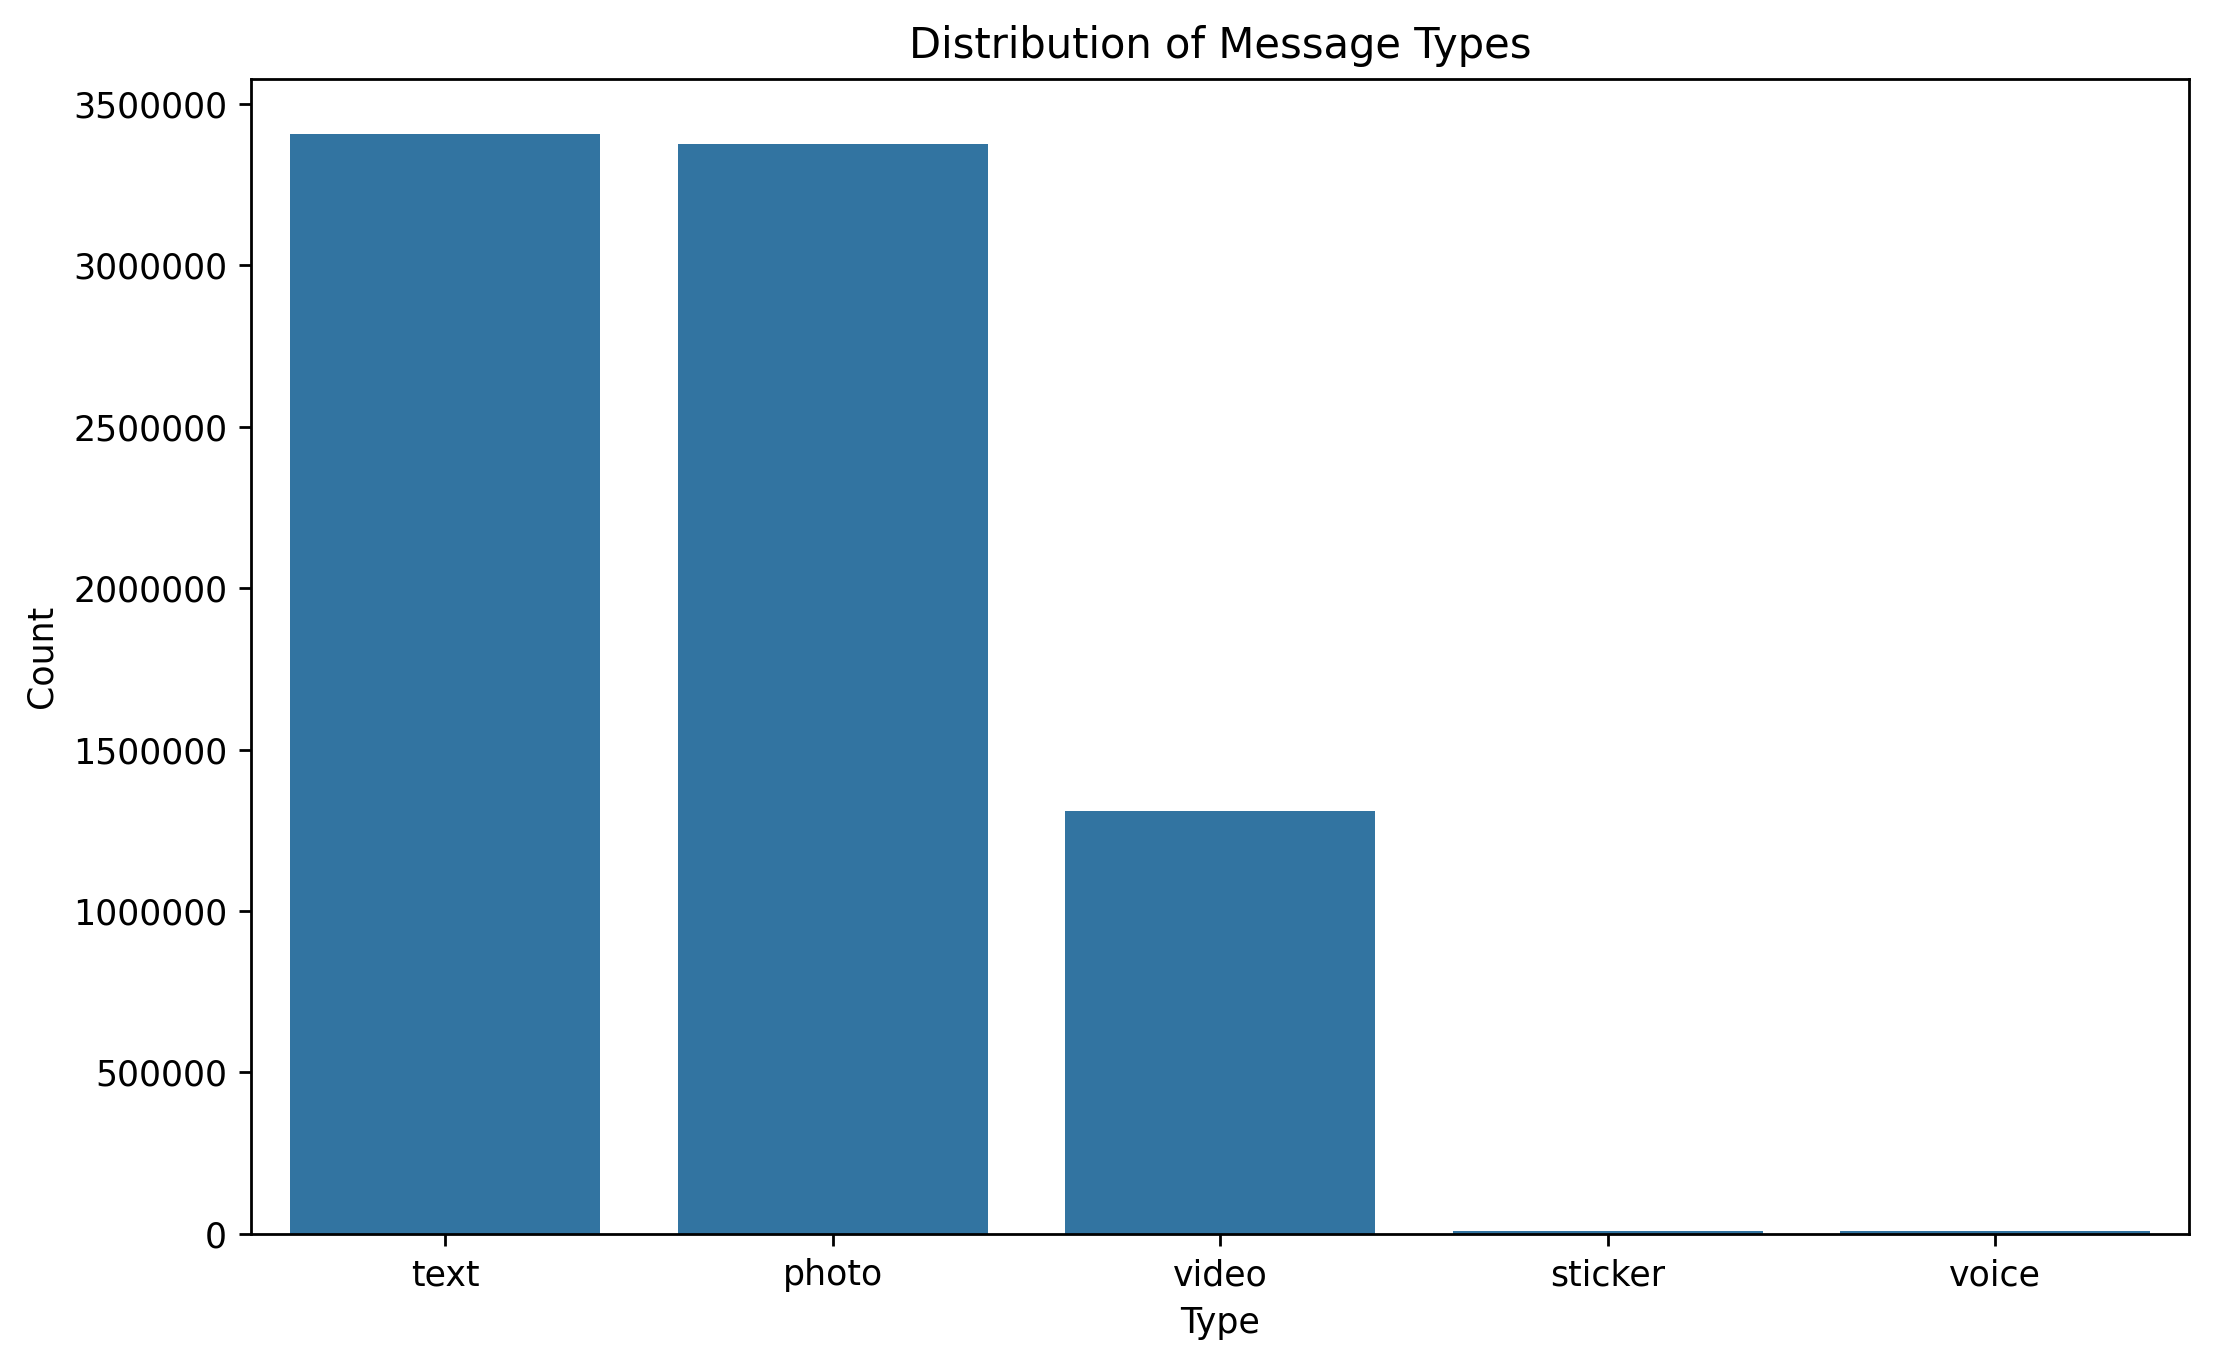

In [6]:
plt.figure(figsize=(10, 6), dpi=250)
plt.ticklabel_format(style = 'plain')
sns.countplot(x=df['type'])
plt.title('Distribution of Message Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

### **Views**

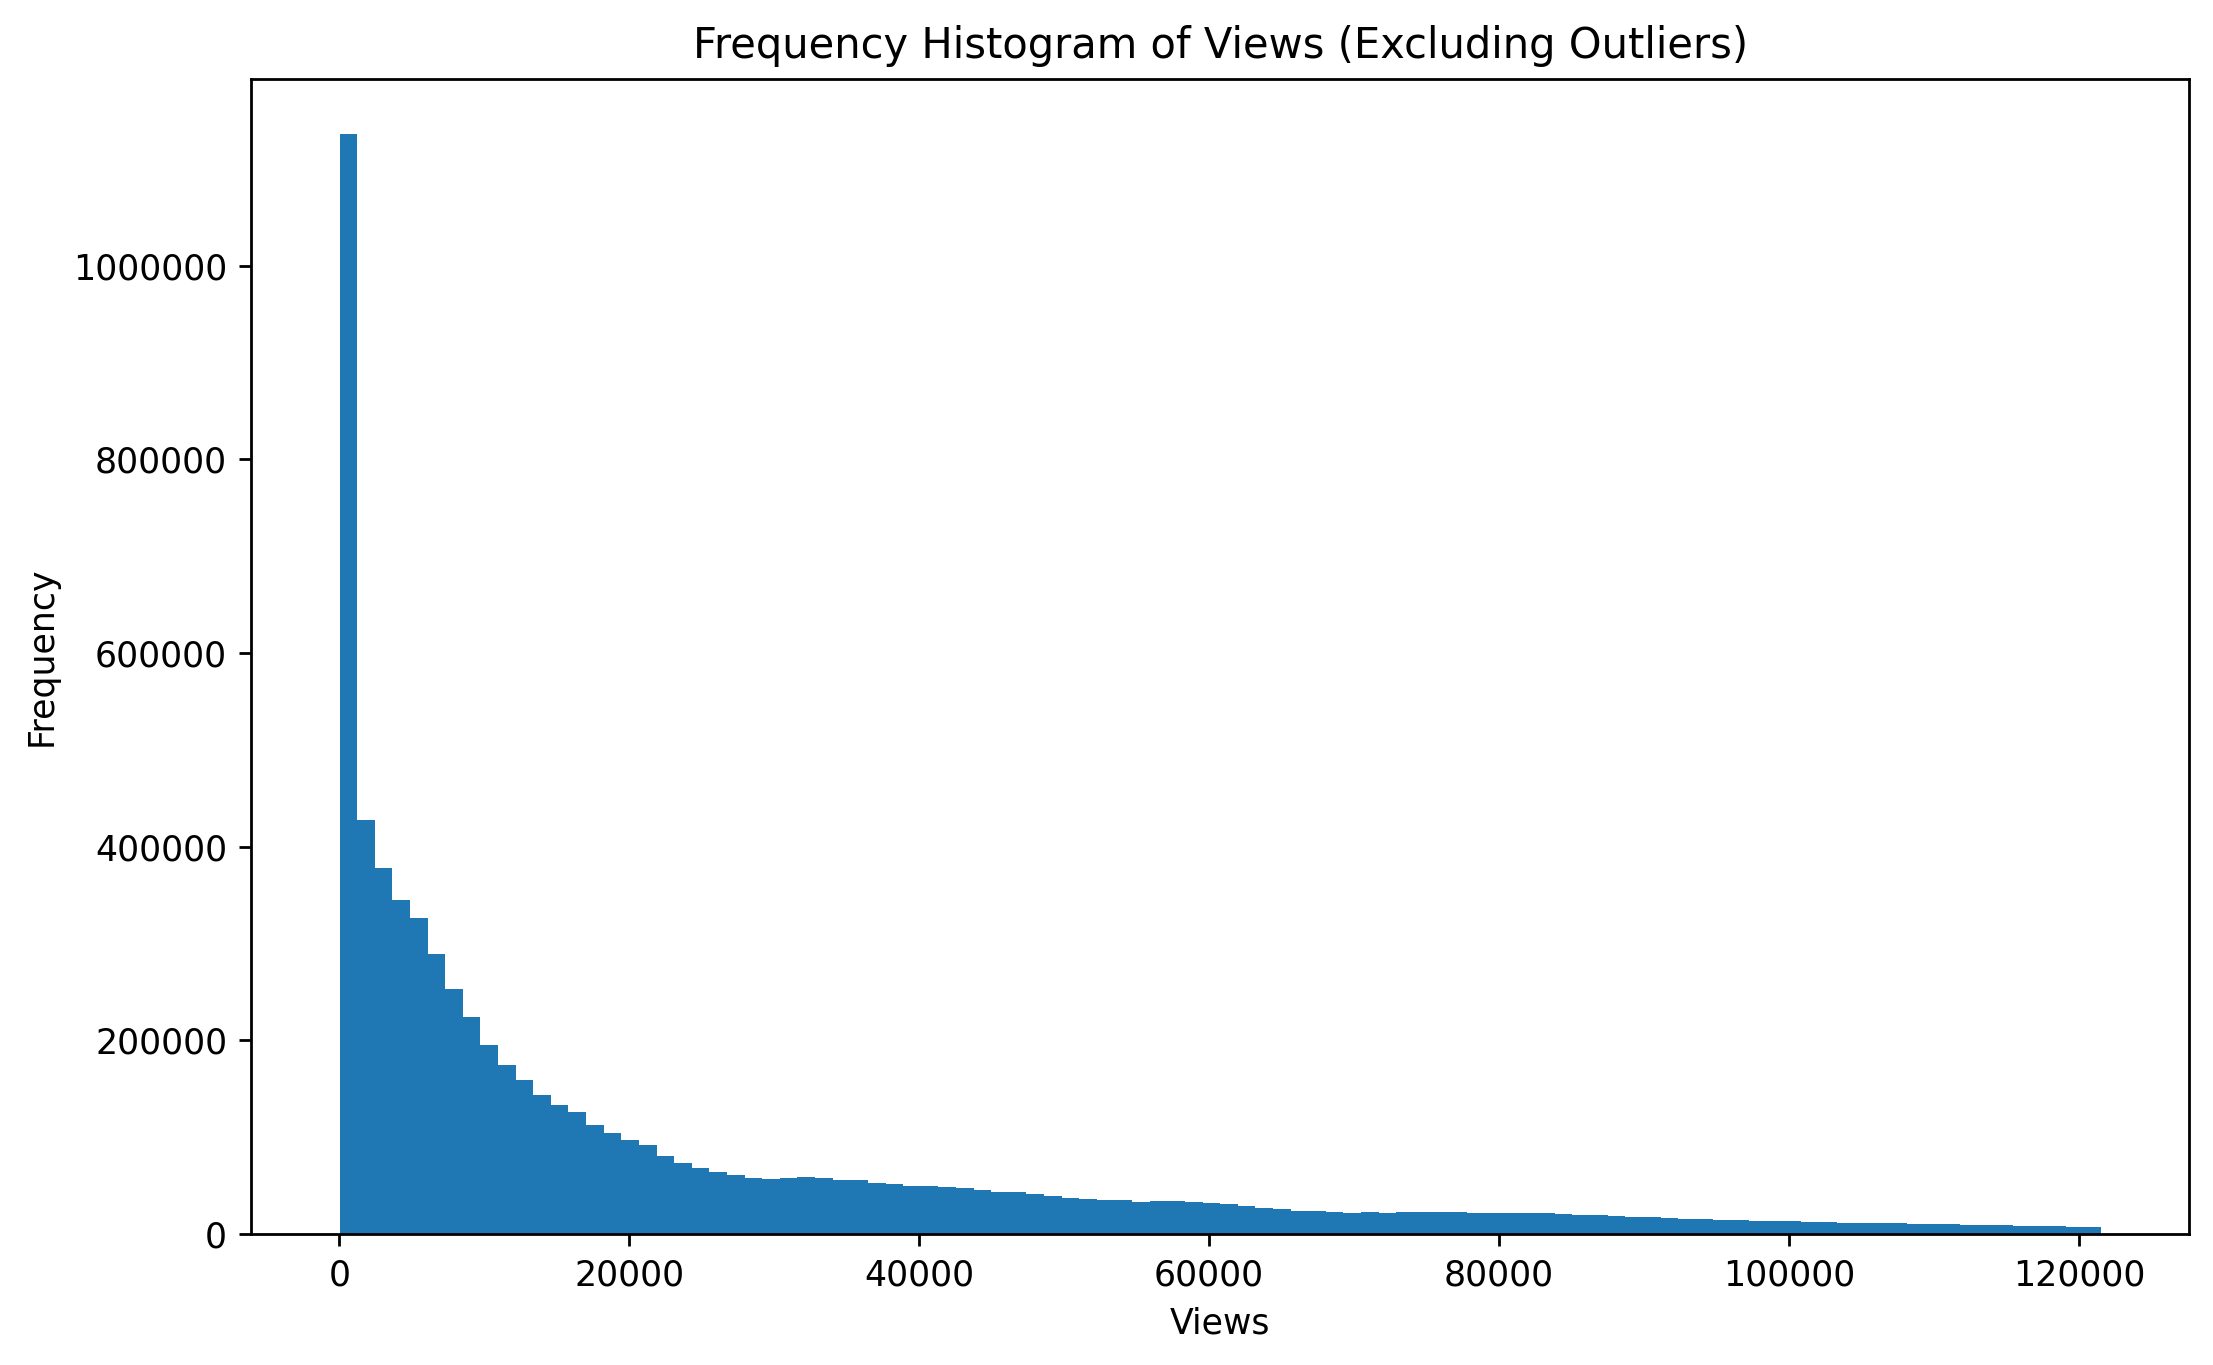

In [7]:
views_threshold = df['views'].quantile(0.90)
filtered_views = df.filter(pl.col('views') <= views_threshold)['views']

plt.figure(figsize=(10, 6), dpi=250)
plt.ticklabel_format(style='plain')
plt.hist(filtered_views, bins=100)
plt.title('Frequency Histogram of Views (Excluding Outliers)')
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.show()

### **Channels**

In [8]:
channel_sum_views = (
    df.group_by('channel')
    .agg(pl.col('views').sum().alias('sum_views'))
    .sort('sum_views', descending=True)
    .head(10)
)

channel_avg_views = (
    df.group_by('channel')
    .agg(pl.col('views').mean().alias('avg_views'))
    .sort('avg_views', descending=True)
    .head(10)
)

top_sensitive_topics = (
    df.filter(pl.col('sensitive-topic') != "none")
    .group_by('sensitive-topic')
    .agg(pl.count().alias('count'))
    .sort('count', descending=True)
    .head(10)
)

channel_counts = df.group_by('channel').count().sort('count', descending=True).head(10)

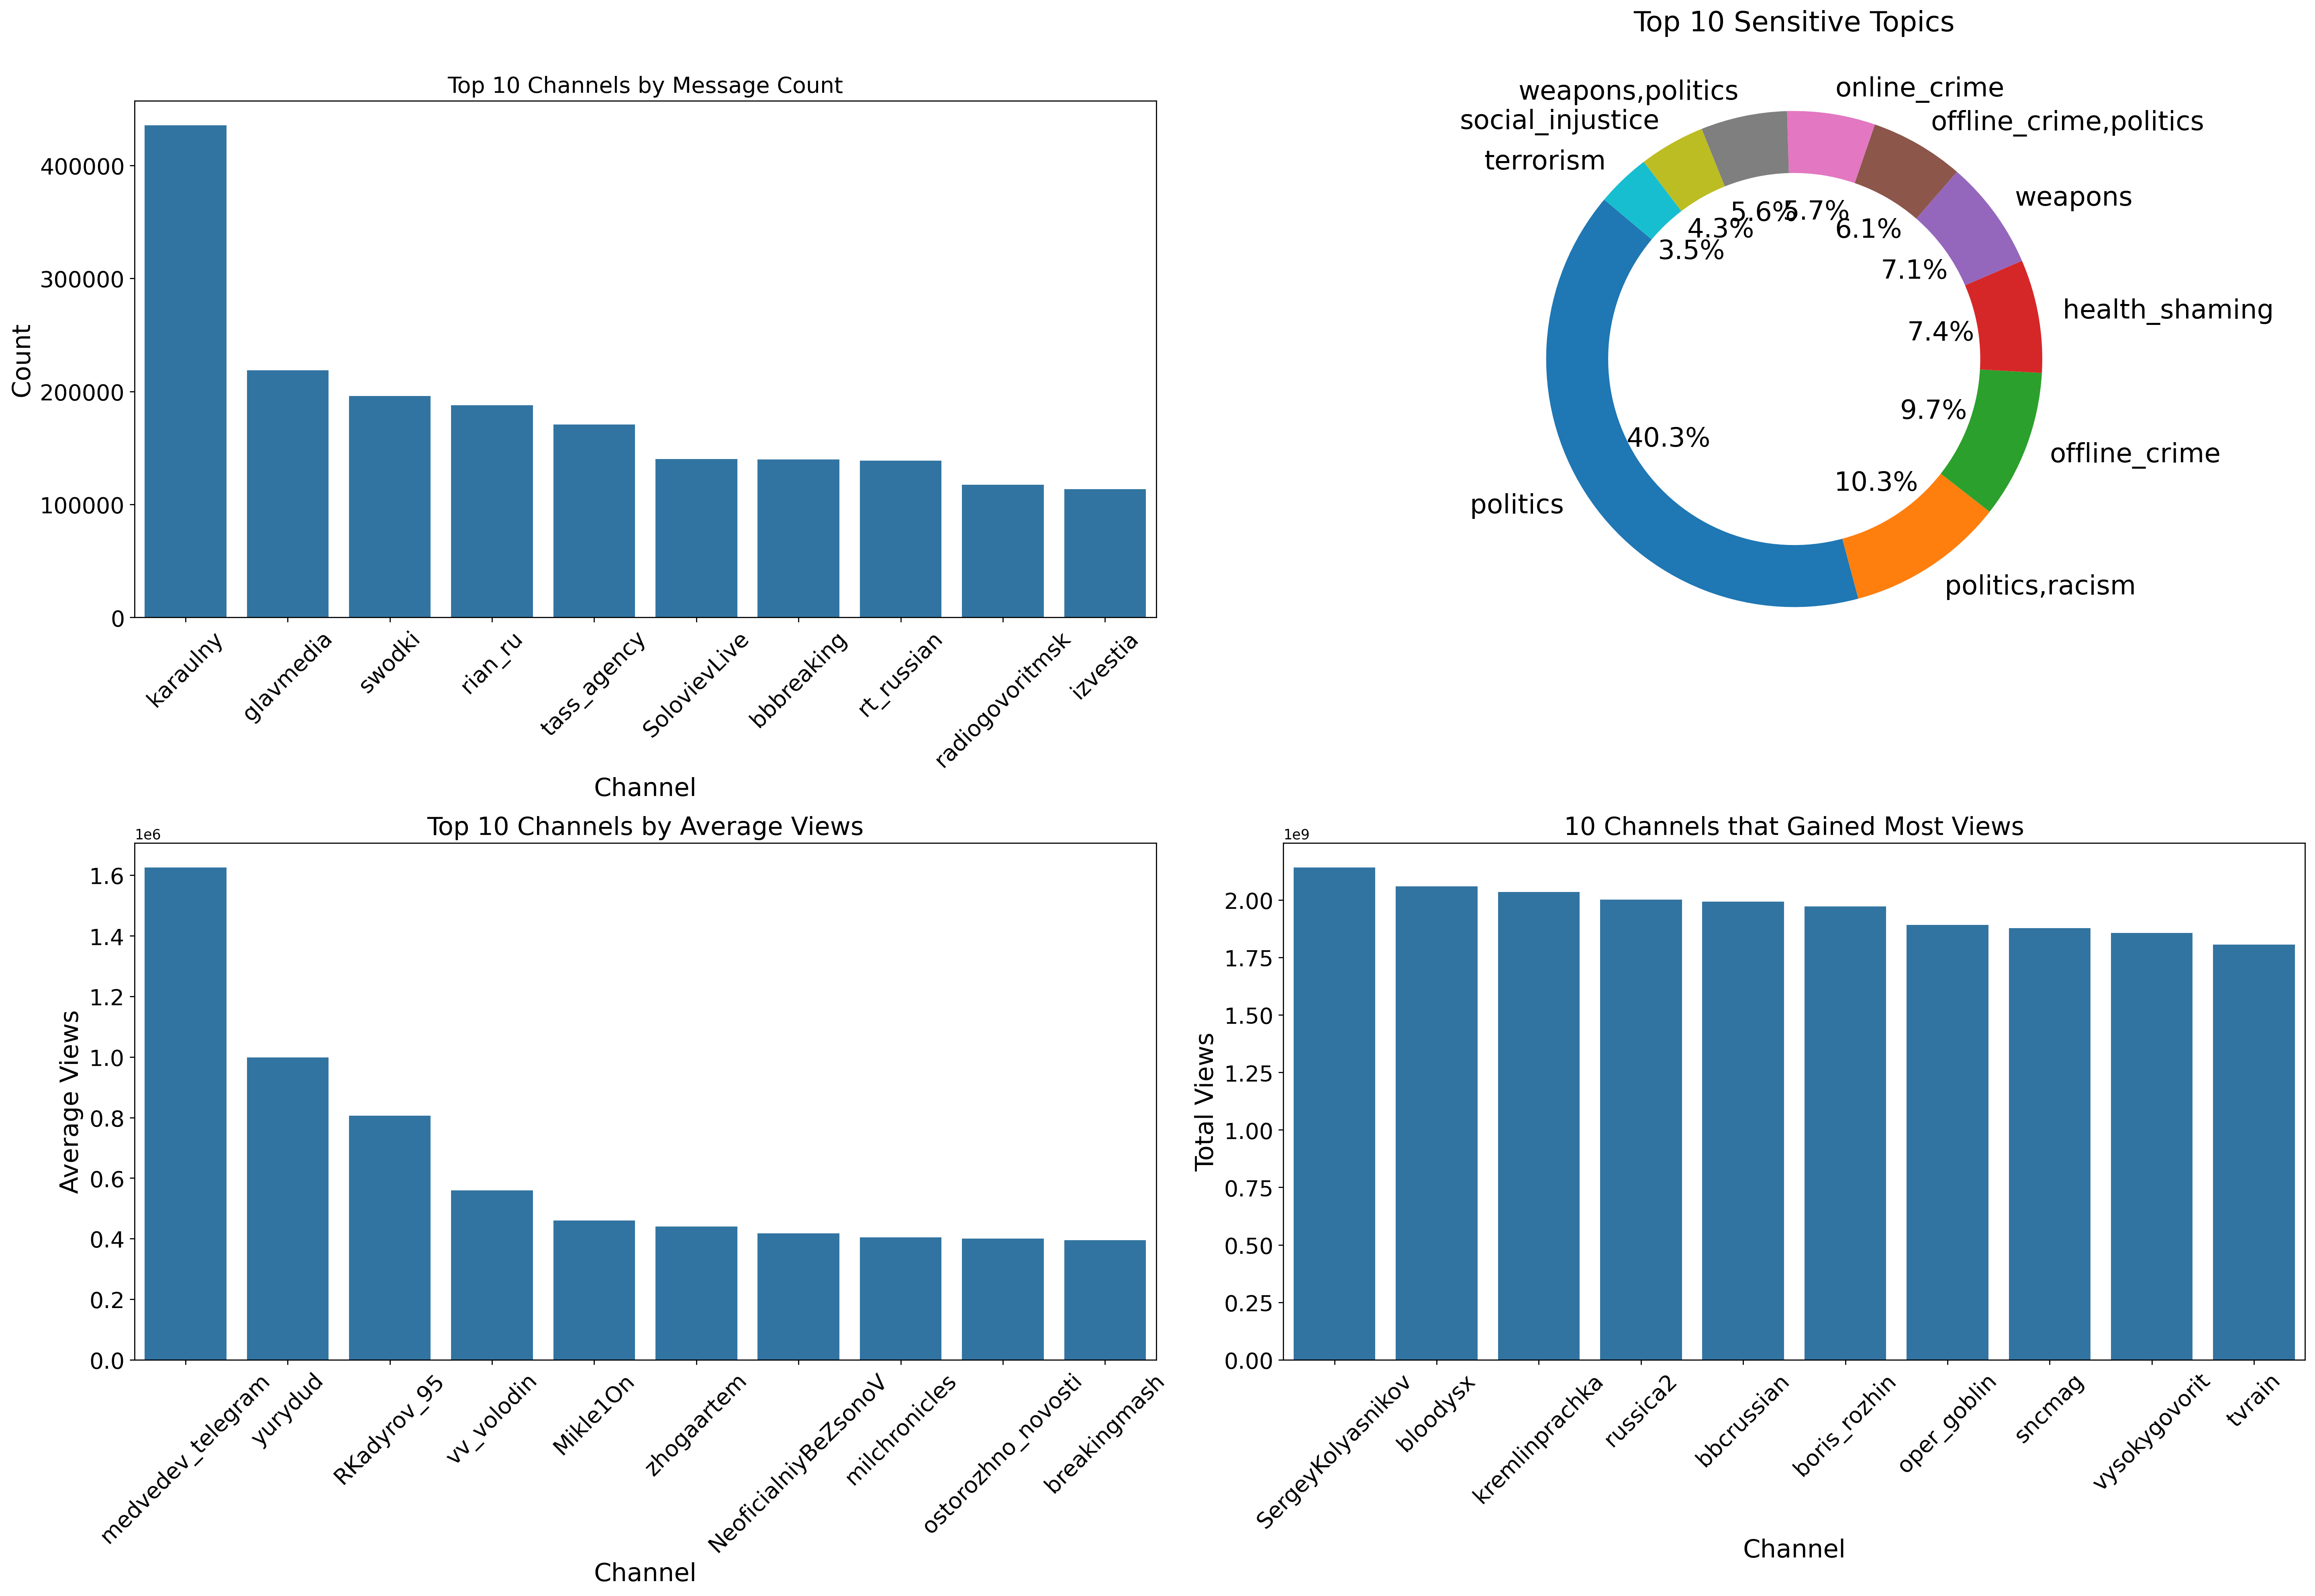

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(24, 16), dpi=250)
font_size, label_size = 18, 16

# Plot for Top 10 Channels by Message Count
sns.barplot(data=channel_counts, x='channel', y='count', ax=axes[0, 0])
axes[0, 0].set_title('Top 10 Channels by Message Count', fontsize=16)
axes[0, 0].set_xlabel('Channel', fontsize=font_size)
axes[0, 0].set_ylabel('Count', fontsize=font_size)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=label_size)
axes[0, 0].tick_params(axis='y', labelsize=label_size)

# Plot for Top 10 Sensitive Topics
labels = top_sensitive_topics['sensitive-topic'].to_list()
sizes = top_sensitive_topics['count'].to_list()
wedges, texts, autotexts = axes[0, 1].pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3}, radius=1.2
)
axes[0, 1].set_title('Top 10 Sensitive Topics', fontsize=font_size+2, pad=50)  # Increase pad to add distance

for text in texts:
    text.set_fontsize(label_size + 3)

for autotext in autotexts:
    autotext.set_fontsize(label_size + 3)

sns.barplot(data=channel_avg_views, x='channel', y='avg_views', ax=axes[1, 0])
axes[1, 0].set_title('Top 10 Channels by Average Views', fontsize=font_size)
axes[1, 0].set_xlabel('Channel', fontsize=font_size)
axes[1, 0].set_ylabel('Average Views', fontsize=font_size)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=label_size)
axes[1, 0].tick_params(axis='y', labelsize=label_size)

sns.barplot(data=channel_sum_views, x='channel', y='sum_views', ax=axes[1, 1])
axes[1, 1].set_title('10 Channels that Gained Most Views', fontsize=font_size)
axes[1, 1].set_xlabel('Channel', fontsize=font_size)
axes[1, 1].set_ylabel('Total Views', fontsize=font_size)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=label_size)
axes[1, 1].tick_params(axis='y', labelsize=label_size)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.show()

## **In-depth analysis**

## **Sensitive topics:** Main Actors

### Which channels were responsible for three of the top crime sensitive topic categories (terrorism, online crimes, offline crimes)?

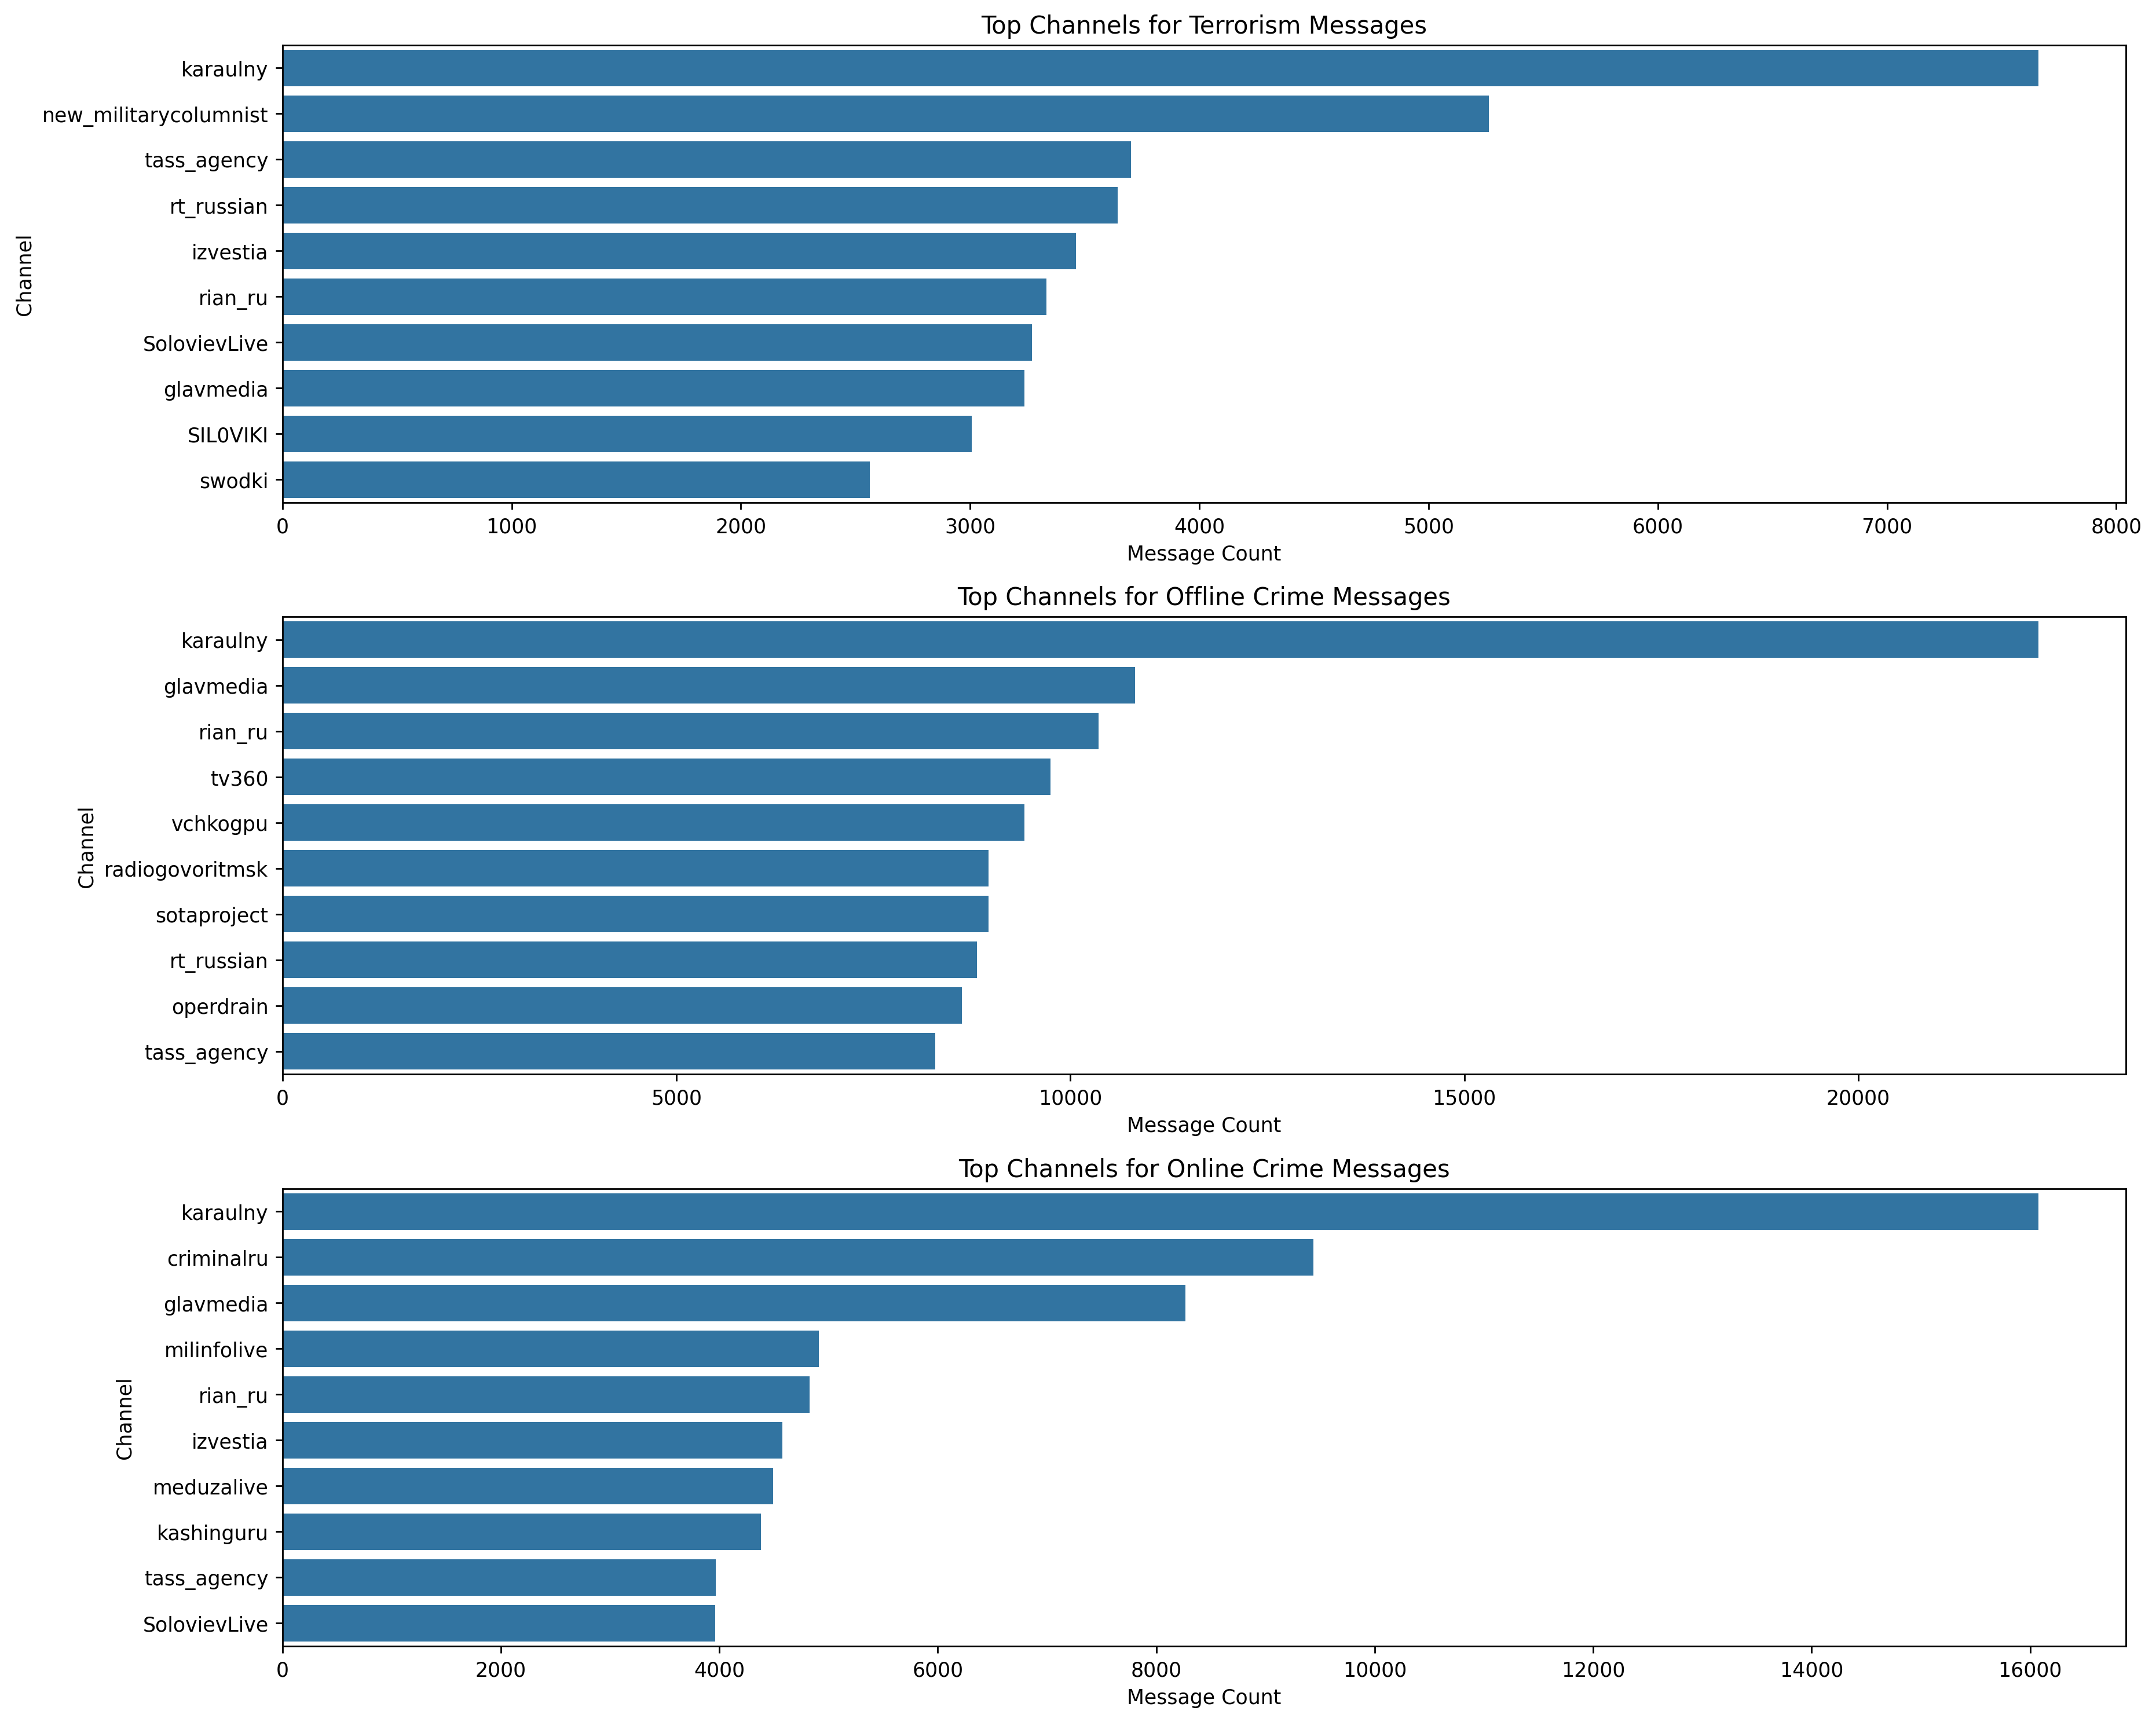

In [10]:
categories = ["terrorism", "offline_crime", "online_crime"]
plt.figure(figsize=(15, 12), dpi=250)

for i, category in enumerate(categories, start=1):
    category_df = df.filter(pl.col("sensitive-topic") == category)
    
    top_channels = (
        category_df
        .group_by("channel")
        .agg(pl.count().alias("count"))
        .sort("count", descending=True)
        .head(10)  
    )
    
    top_channels_pd = top_channels.to_pandas()

    plt.subplot(3, 1, i)
    sns.barplot(data=top_channels_pd, x="count", y="channel")
    plt.title(f"Top Channels for {category.replace('_', ' ').title()} Messages")
    plt.xlabel("Message Count")
    plt.ylabel("Channel")

plt.tight_layout()
plt.show()

### What channels that were most viewed in these crime categories?

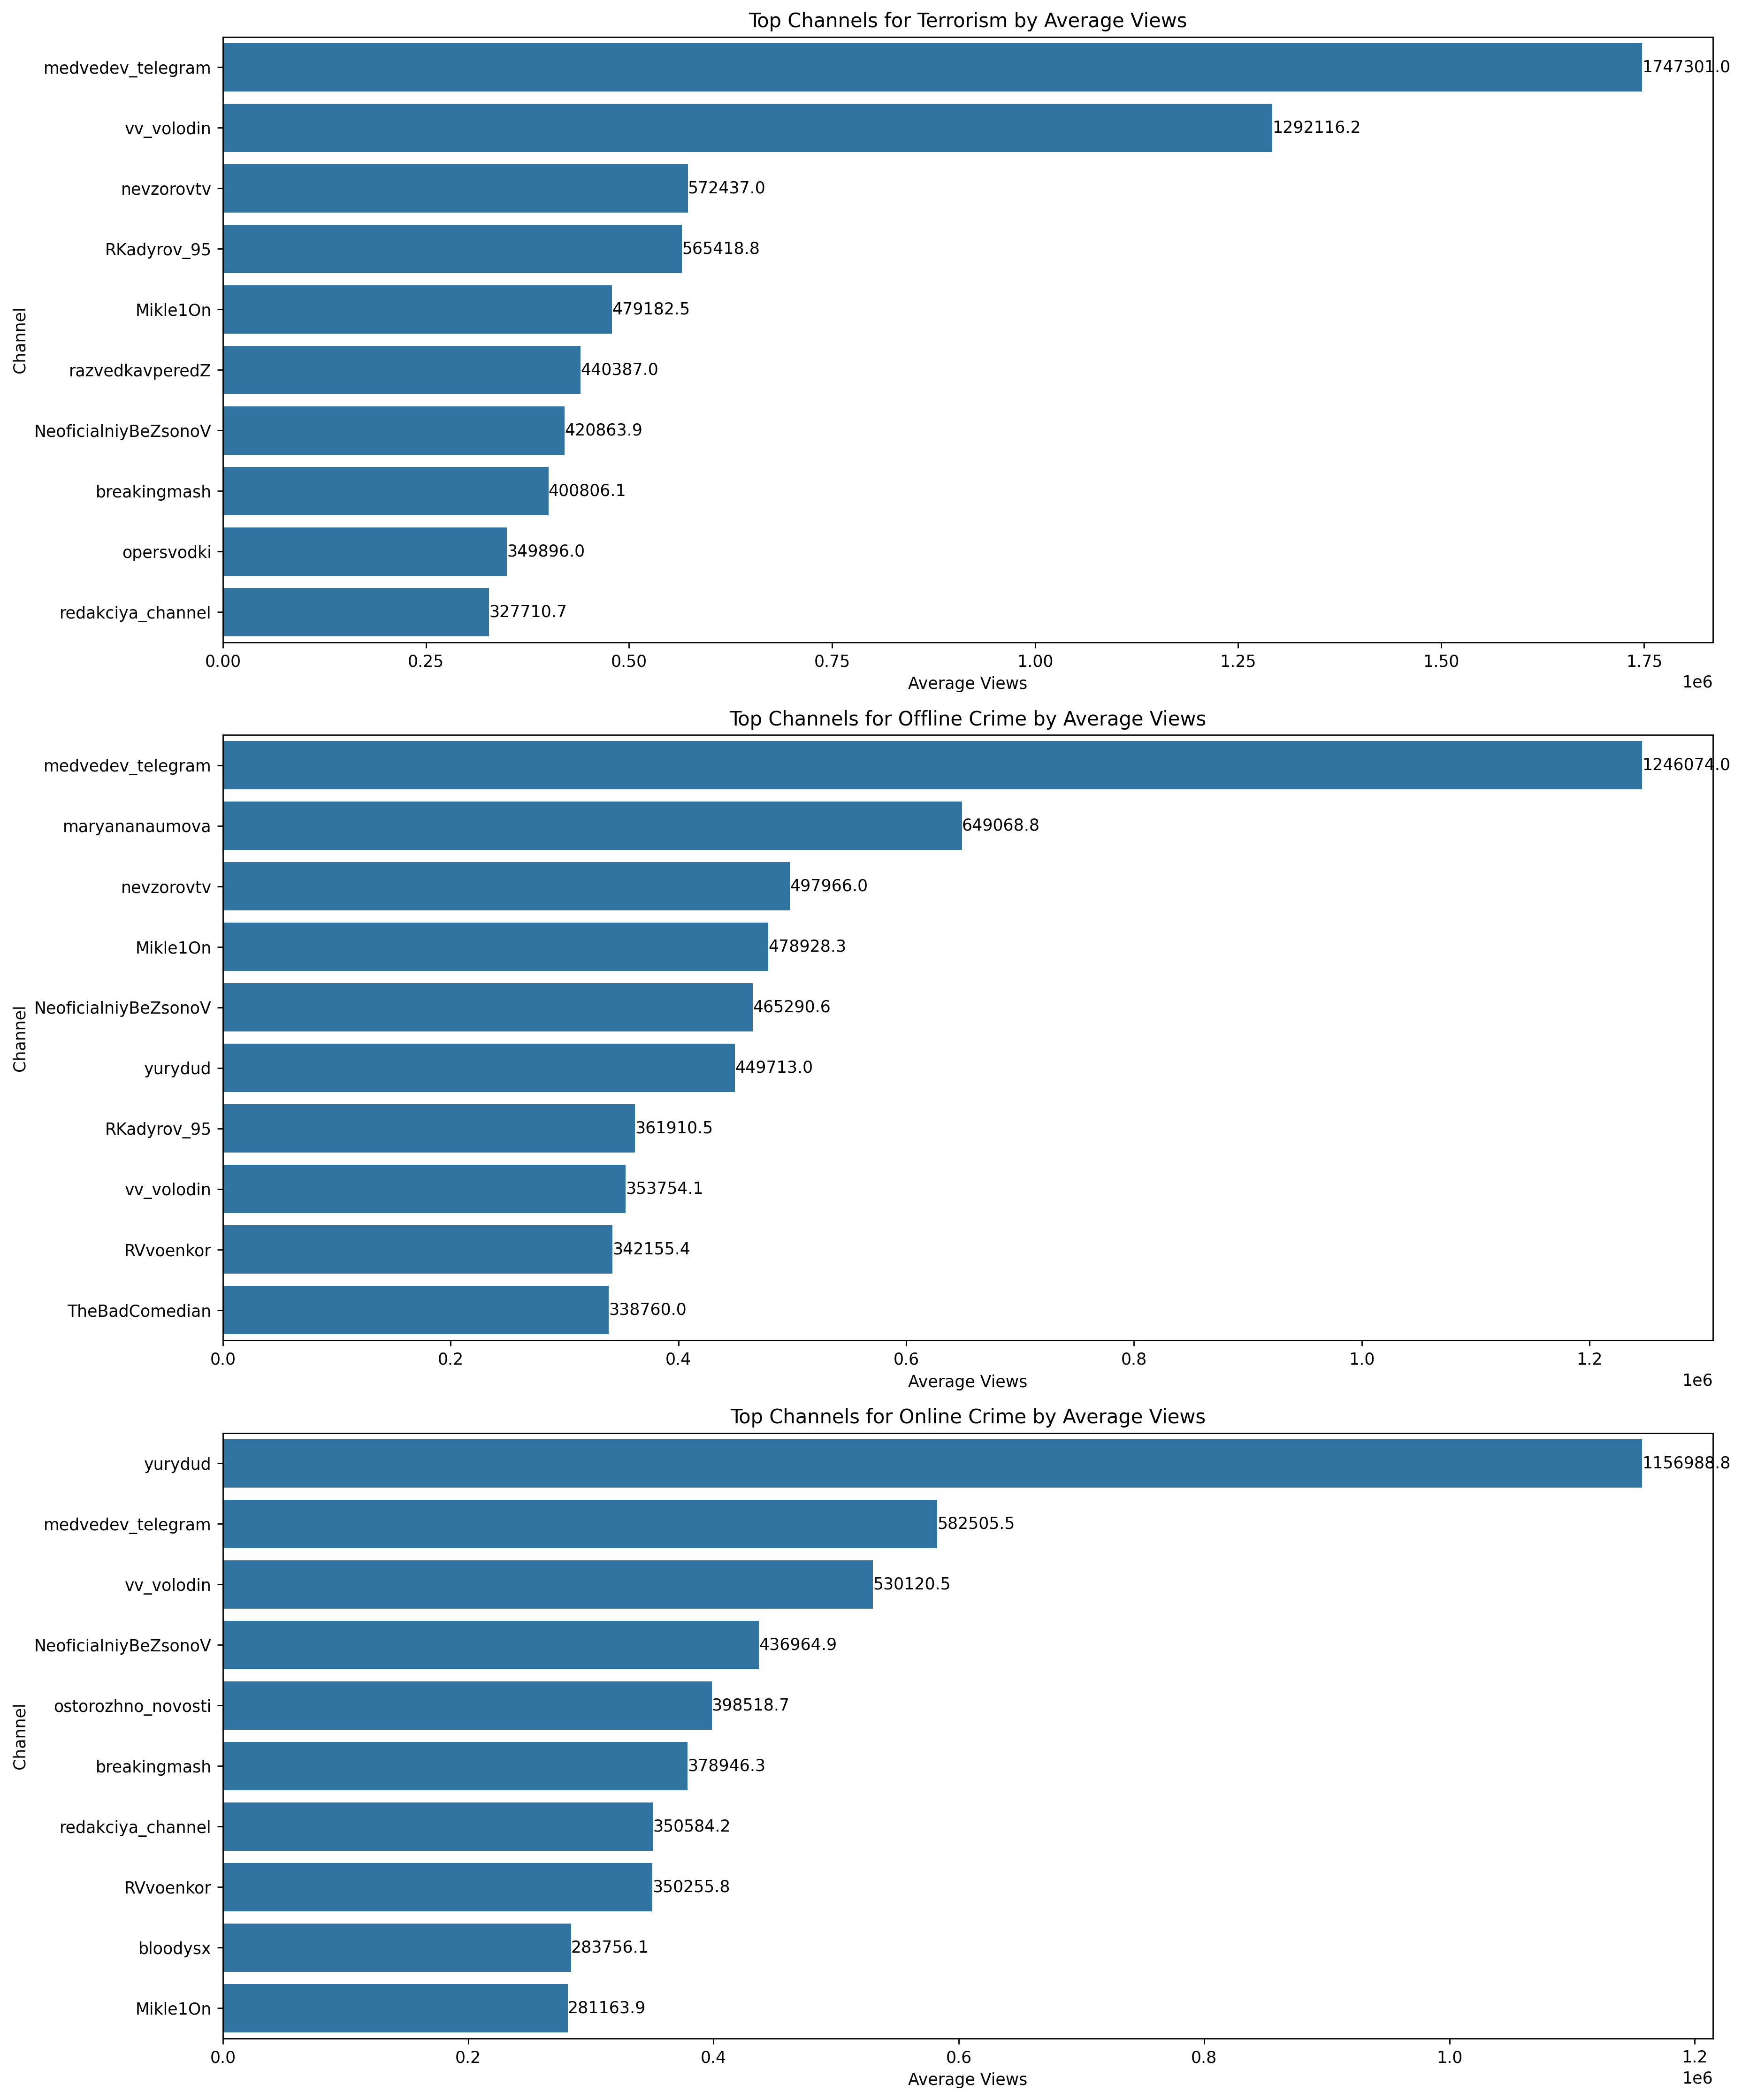

In [11]:
categories = ["terrorism", "offline_crime", "online_crime"]
plt.figure(figsize=(15, 18), dpi=250)

for i, category in enumerate(categories, start=1):
    category_df = df.filter(pl.col("sensitive-topic") == category)
    top_channels_avg_views = (
        category_df
        .group_by("channel")
        .agg(pl.col("views").mean().alias("avg_views"))
        .sort("avg_views", descending=True)
        .head(10)
    )
    
    top_channels_avg_views_pd = top_channels_avg_views.to_pandas()
    
    plt.subplot(3, 1, i)
    sns.barplot(data=top_channels_avg_views_pd, x="avg_views", y="channel")
    plt.title(f"Top Channels for {category.replace('_', ' ').title()} by Average Views")
    plt.xlabel("Average Views")
    plt.ylabel("Channel")
    
    for index, value in enumerate(top_channels_avg_views_pd['avg_views']):
        plt.text(value, index, f'{value:.1f}', va='center')

plt.tight_layout()
plt.show()

## **Toxicity Analysis**

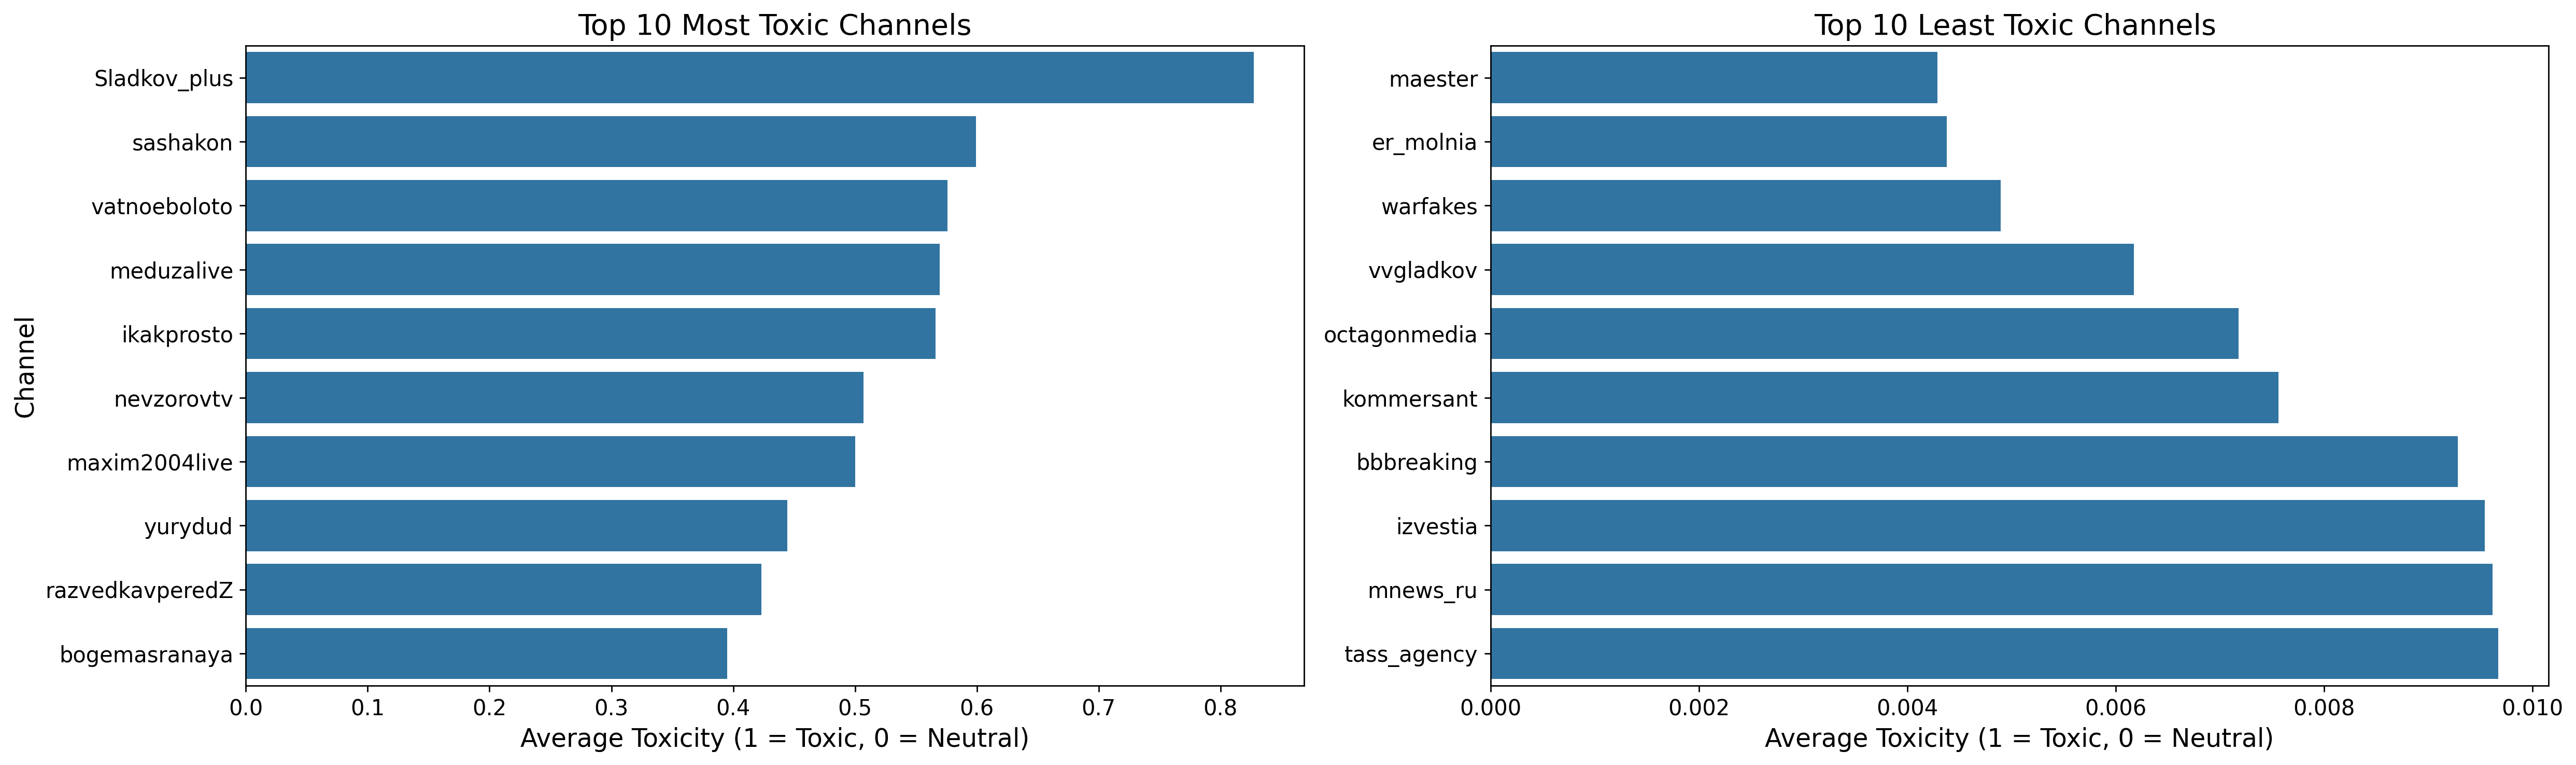

In [14]:
politics_df = df.filter(pl.col("sensitive-topic") == "politics")
politics_df = politics_df.with_columns(
    pl.when(pl.col("toxicity") == "toxic").then(1).otherwise(0).alias("toxicity_numeric")
)

top_toxic_channels = (
    politics_df
    .group_by("channel")
    .agg(pl.col("toxicity_numeric").mean().alias("avg_toxicity"))
    .sort("avg_toxicity", descending=True)
    .head(10)  
)

top_toxic_channels_pd = top_toxic_channels.to_pandas()

top_least_toxic_channels = (
    politics_df
    .group_by("channel")
    .agg(pl.col("toxicity_numeric").mean().alias("avg_toxicity"))
    .sort("avg_toxicity", descending=False)
    .filter(pl.col("avg_toxicity") > 0)
    .head(10)
)

top_least_toxic_channels_pd = top_least_toxic_channels.to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(20, 6), dpi=250)

sns.barplot(data=top_toxic_channels_pd, x="avg_toxicity", y="channel", ax=axes[0])
axes[0].set_title("Top 10 Most Toxic Channels", fontsize=16)
axes[0].set_xlabel("Average Toxicity (1 = Toxic, 0 = Neutral)", fontsize=14)
axes[0].set_ylabel("Channel", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

sns.barplot(data=top_least_toxic_channels_pd, x="avg_toxicity", y="channel", ax=axes[1])
axes[1].set_title("Top 10 Least Toxic Channels ", fontsize=16)
axes[1].set_xlabel("Average Toxicity (1 = Toxic, 0 = Neutral)", fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


As we can see, there are channels:
 - that produced extremely toxic content, the toxicity level of which ranged as high as 0.8.
 - posted almost no toxic content about politics (the least toxic channel `maester` scored around 0.004 on toxicity level)

The question that arises naturally is how successful these channels were in their popularity and reach in terms of toxicity groups.

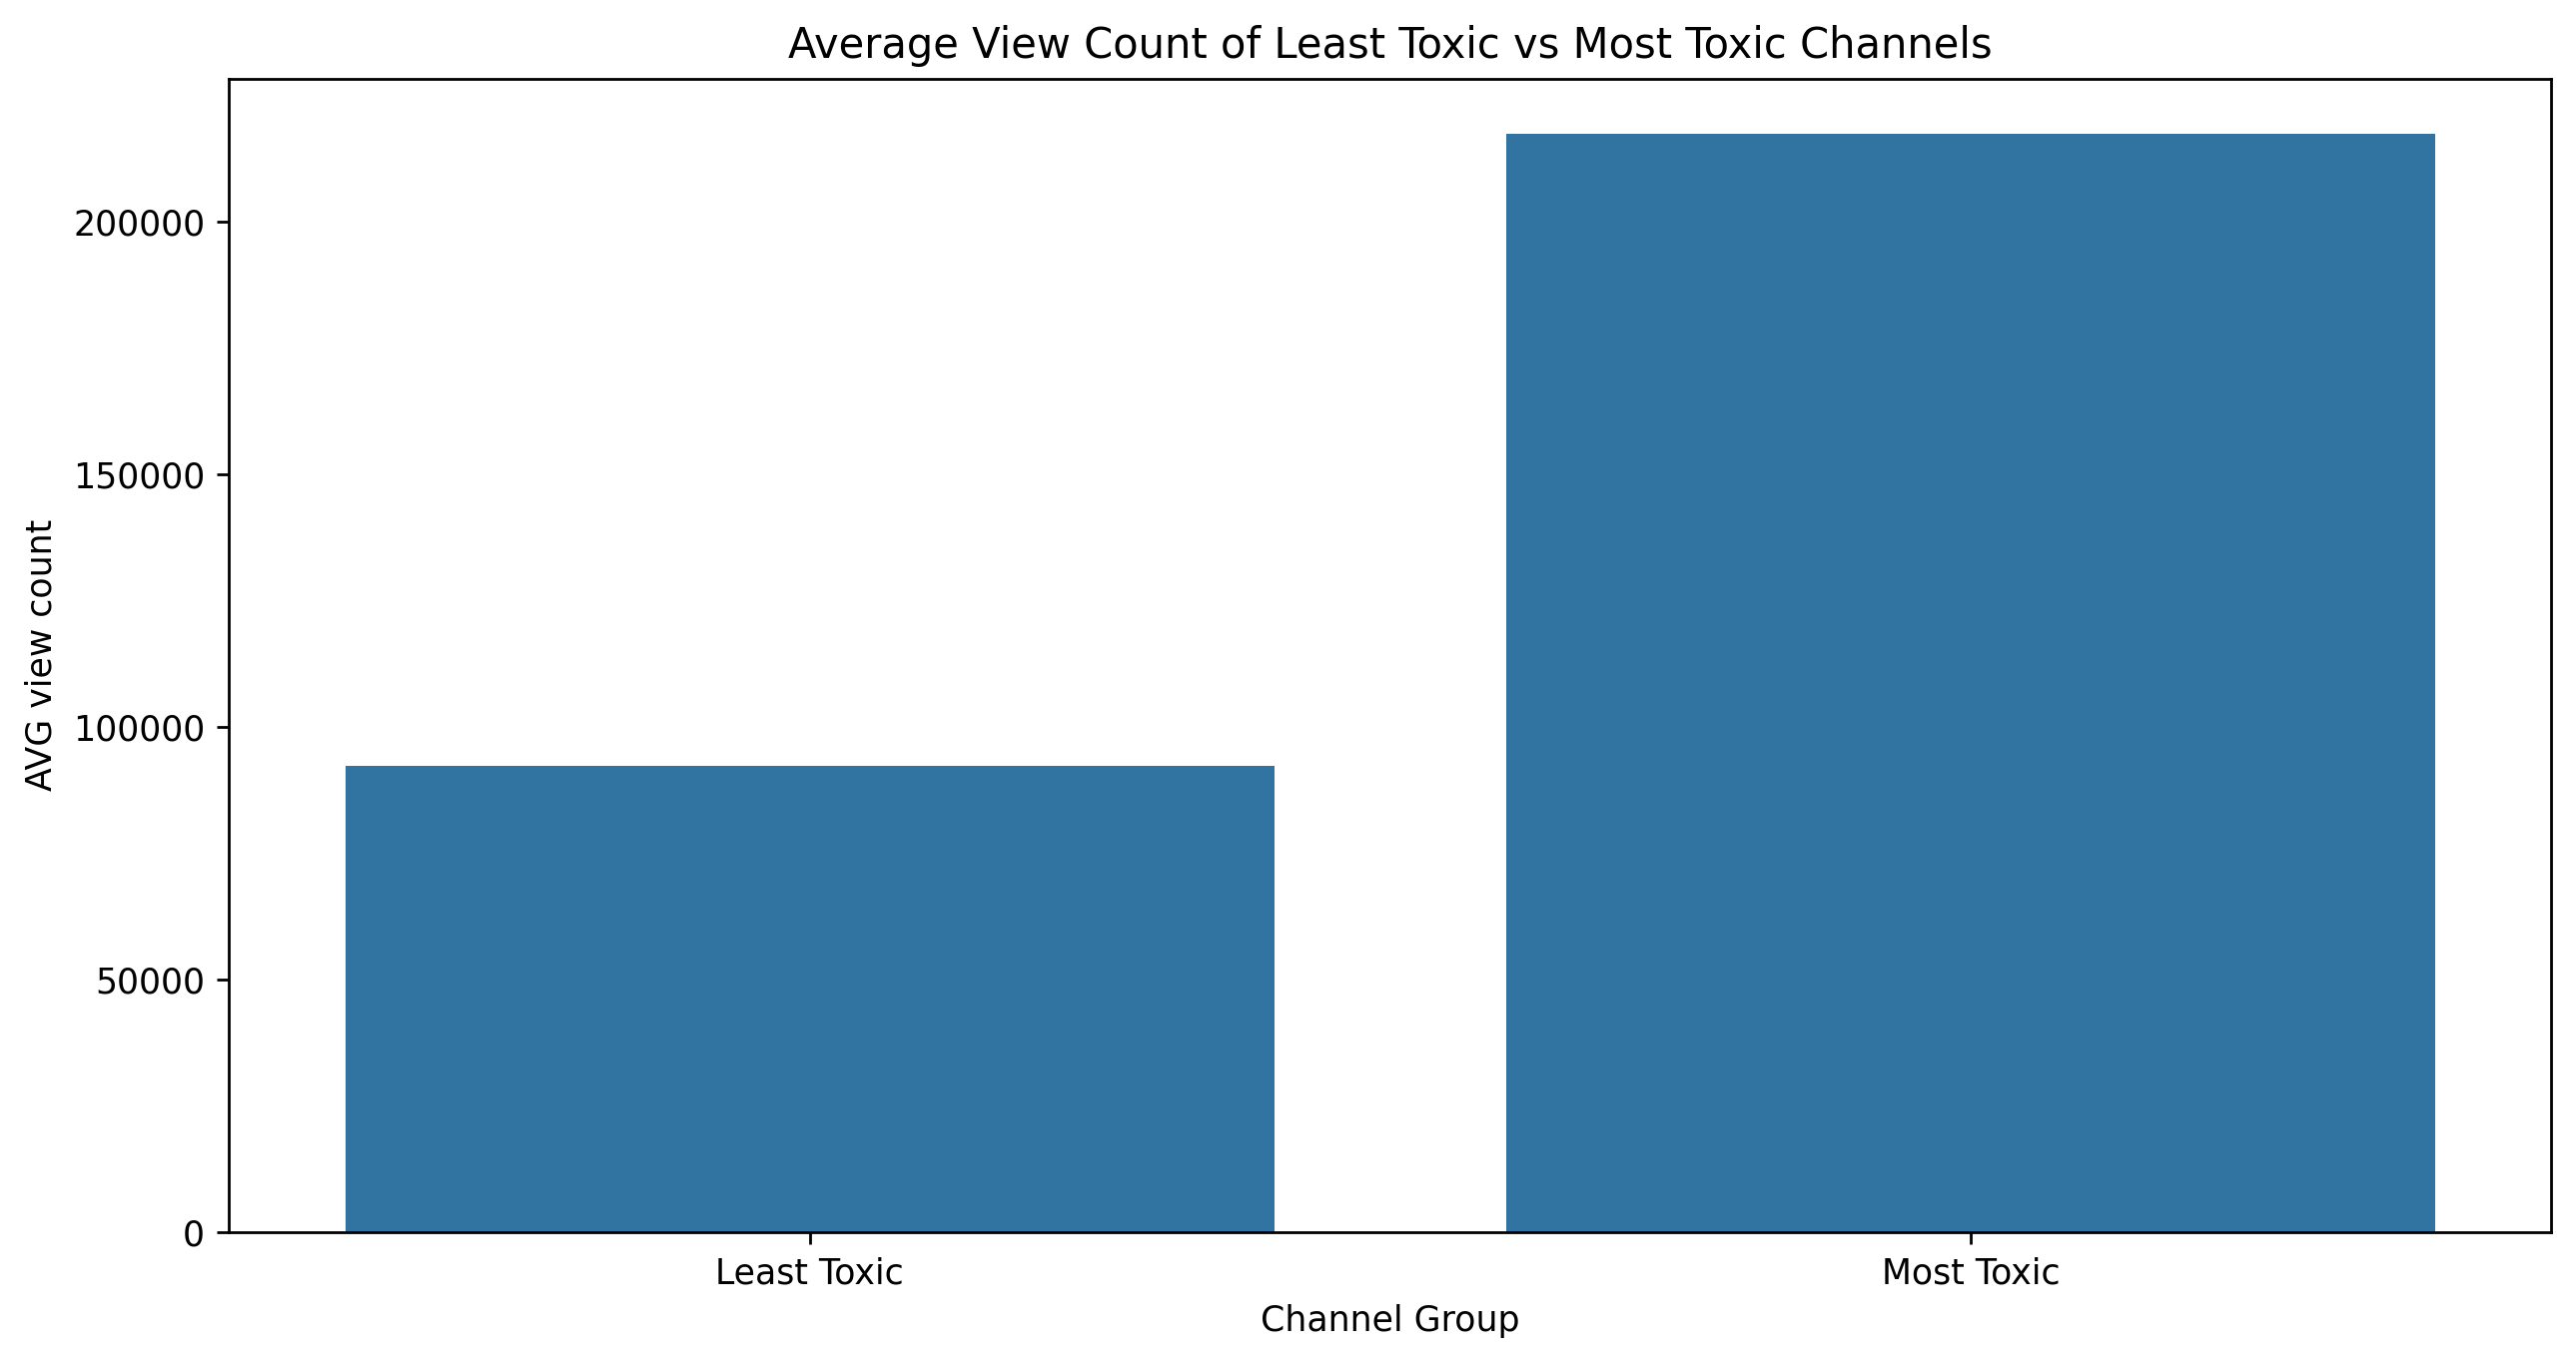

In [16]:
least_toxic_channels_stats = df.filter(pl.col("channel").is_in(top_least_toxic_channels_pd['channel'].tolist())).group_by("channel").agg([
    pl.col("views").mean().alias("avg_views")
])

most_toxic_channels_stats = df.filter(pl.col("channel").is_in(top_toxic_channels_pd['channel'].tolist())).group_by("channel").agg([
    pl.col("views").mean().alias("avg_views")
])

least_toxic_channels_stats_pd = least_toxic_channels_stats.to_pandas()
most_toxic_channels_stats_pd = most_toxic_channels_stats.to_pandas()

least_toxic_channels_stats_pd, most_toxic_channels_stats_pd
combined_stats = pd.concat([
    least_toxic_channels_stats_pd.assign(group='Least Toxic'),
    most_toxic_channels_stats_pd.assign(group='Most Toxic')
])

plt.figure(figsize=(12, 6), dpi=250)
sns.barplot(data=combined_stats, x='group', y='avg_views', ci=None)
plt.title('Average View Count of Least Toxic vs Most Toxic Channels')
plt.xlabel('Channel Group')
plt.ylabel('AVG view count')
plt.show()

As we see, on average the posts by most toxic channels were viewed almost twice as more than the least toxic channels. This tendency is in line with recent studies of social psychology, which indicate that negative content tends to attract more attention and engagement than positive content. Research has shown that social media users are significantly more likely to share links to negative news articles, with findings suggesting they are 1.91 times more inclined to do so compared to positive articles [1].

References:
1. https://www.nature.com/articles/s41598-024-71263-z

## **Temporal Tendencies**

### What is the overall timely tendency of channels activity?

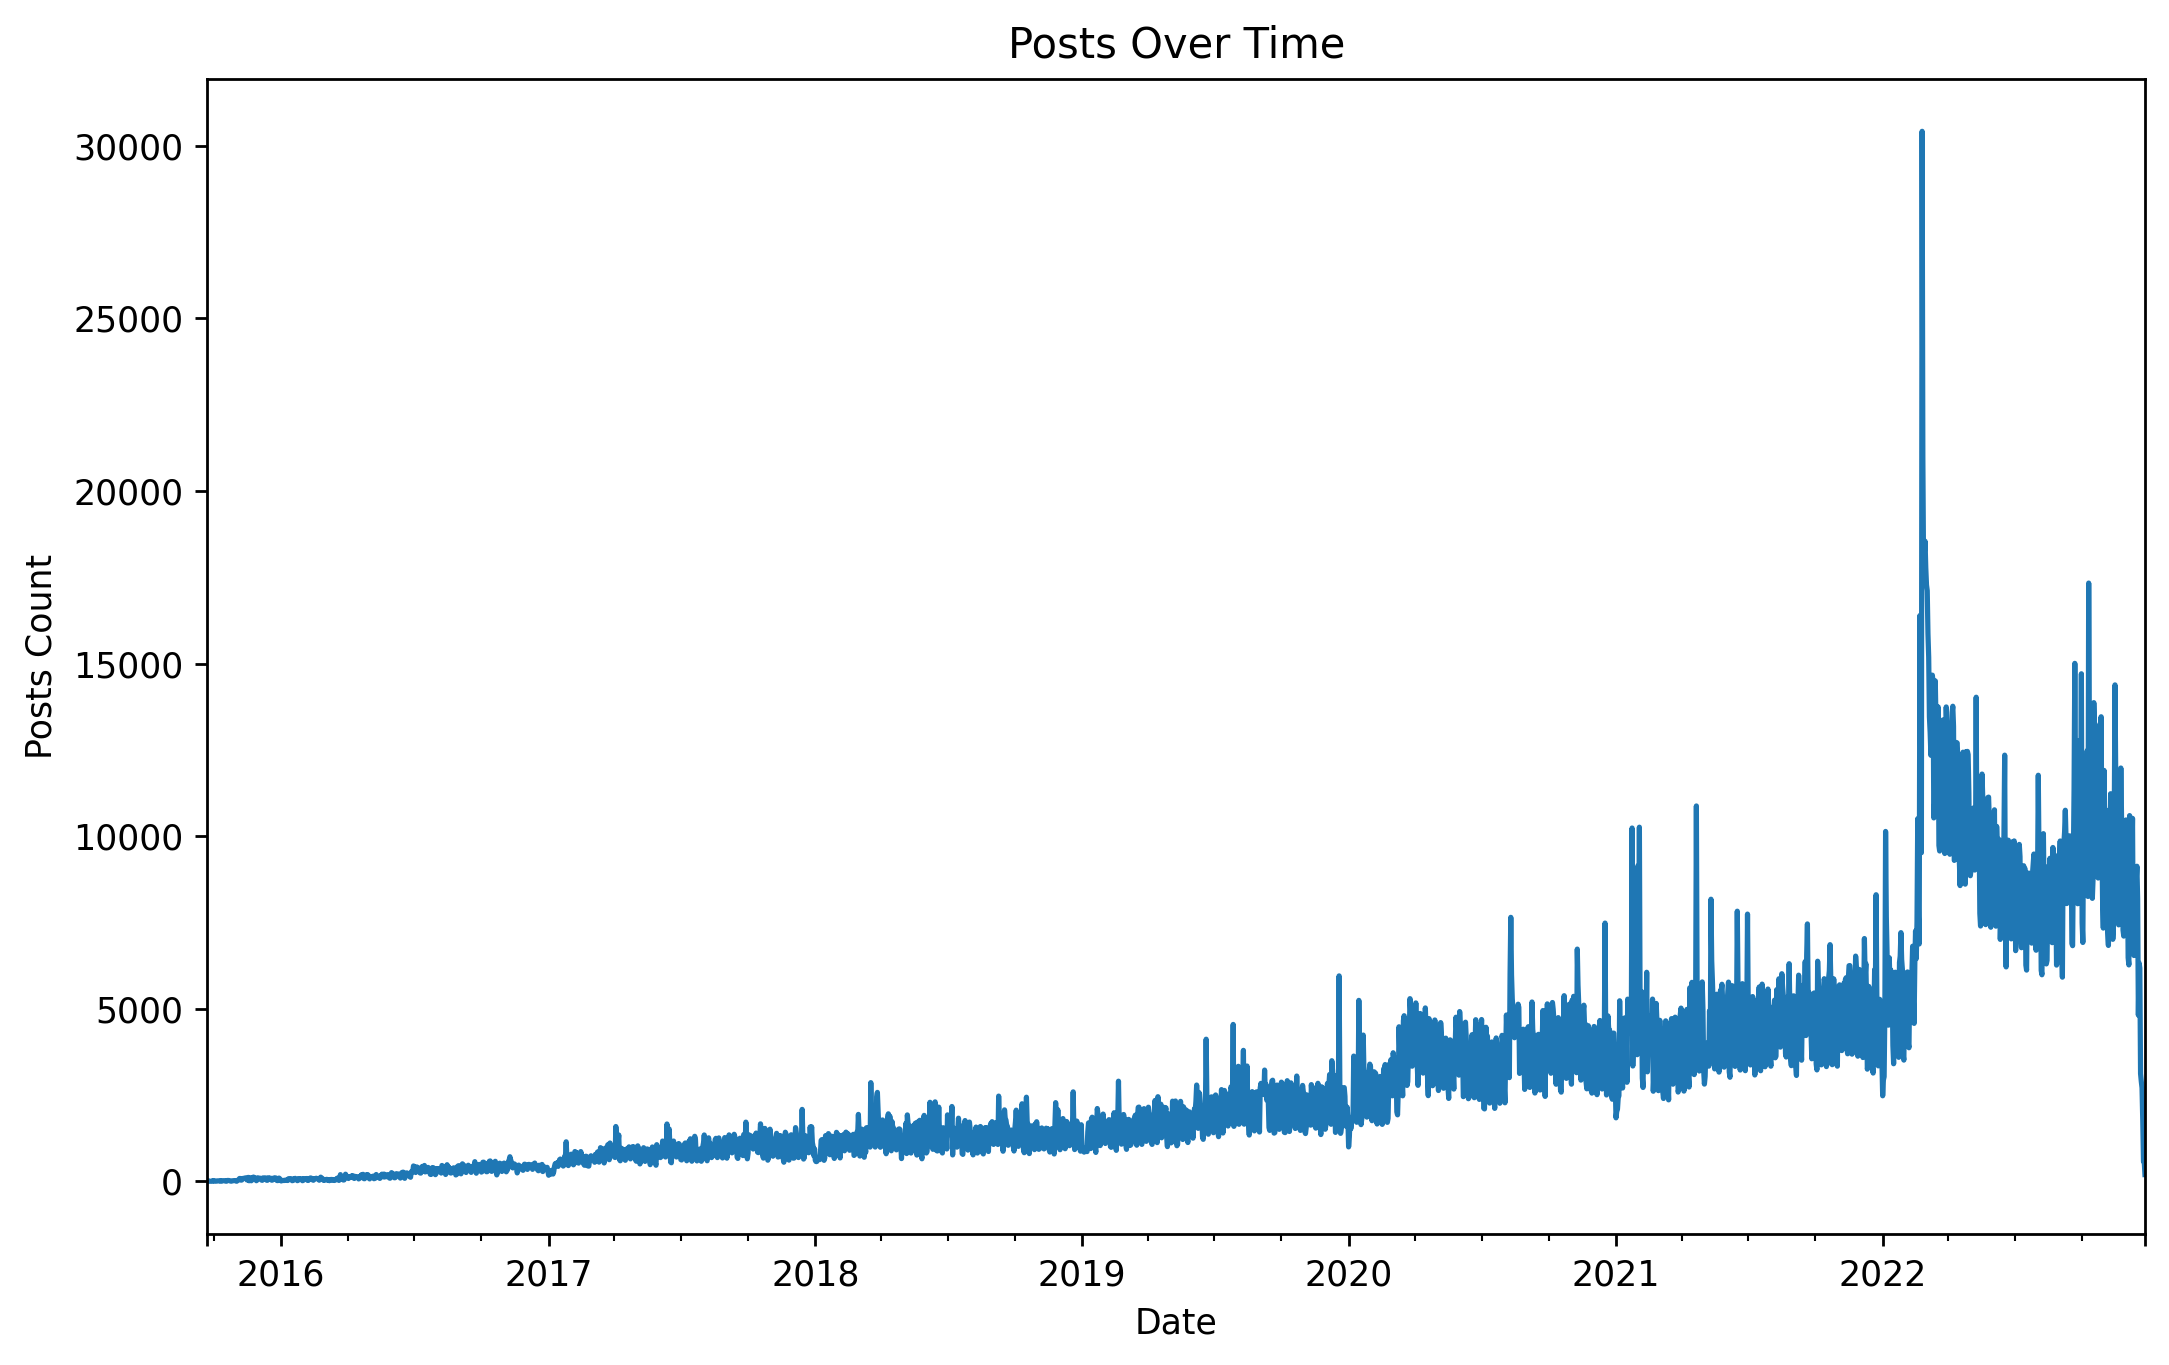

In [14]:
df_pd = df.select(['datetime']).to_pandas()
df_pd.set_index('datetime', inplace=True)
df_pd['message_count'] = 1
message_counts = df_pd.resample('D').sum()

fig, ax = plt.subplots(figsize=(10, 6), dpi=250)
message_counts.plot(y='message_count', ax=ax, title='Posts Over Time')
ax.set_ylabel('Posts Count')
ax.set_xlabel('Date')
ax.legend().set_visible(False)
plt.show()

The posts number was gradually growing over time, which signifies the rising popularity of Telegram messenger among russians and their tendency to consume more content from this platform.

### How did the frequency of posts changed for most active channels? When did they become more/less active?

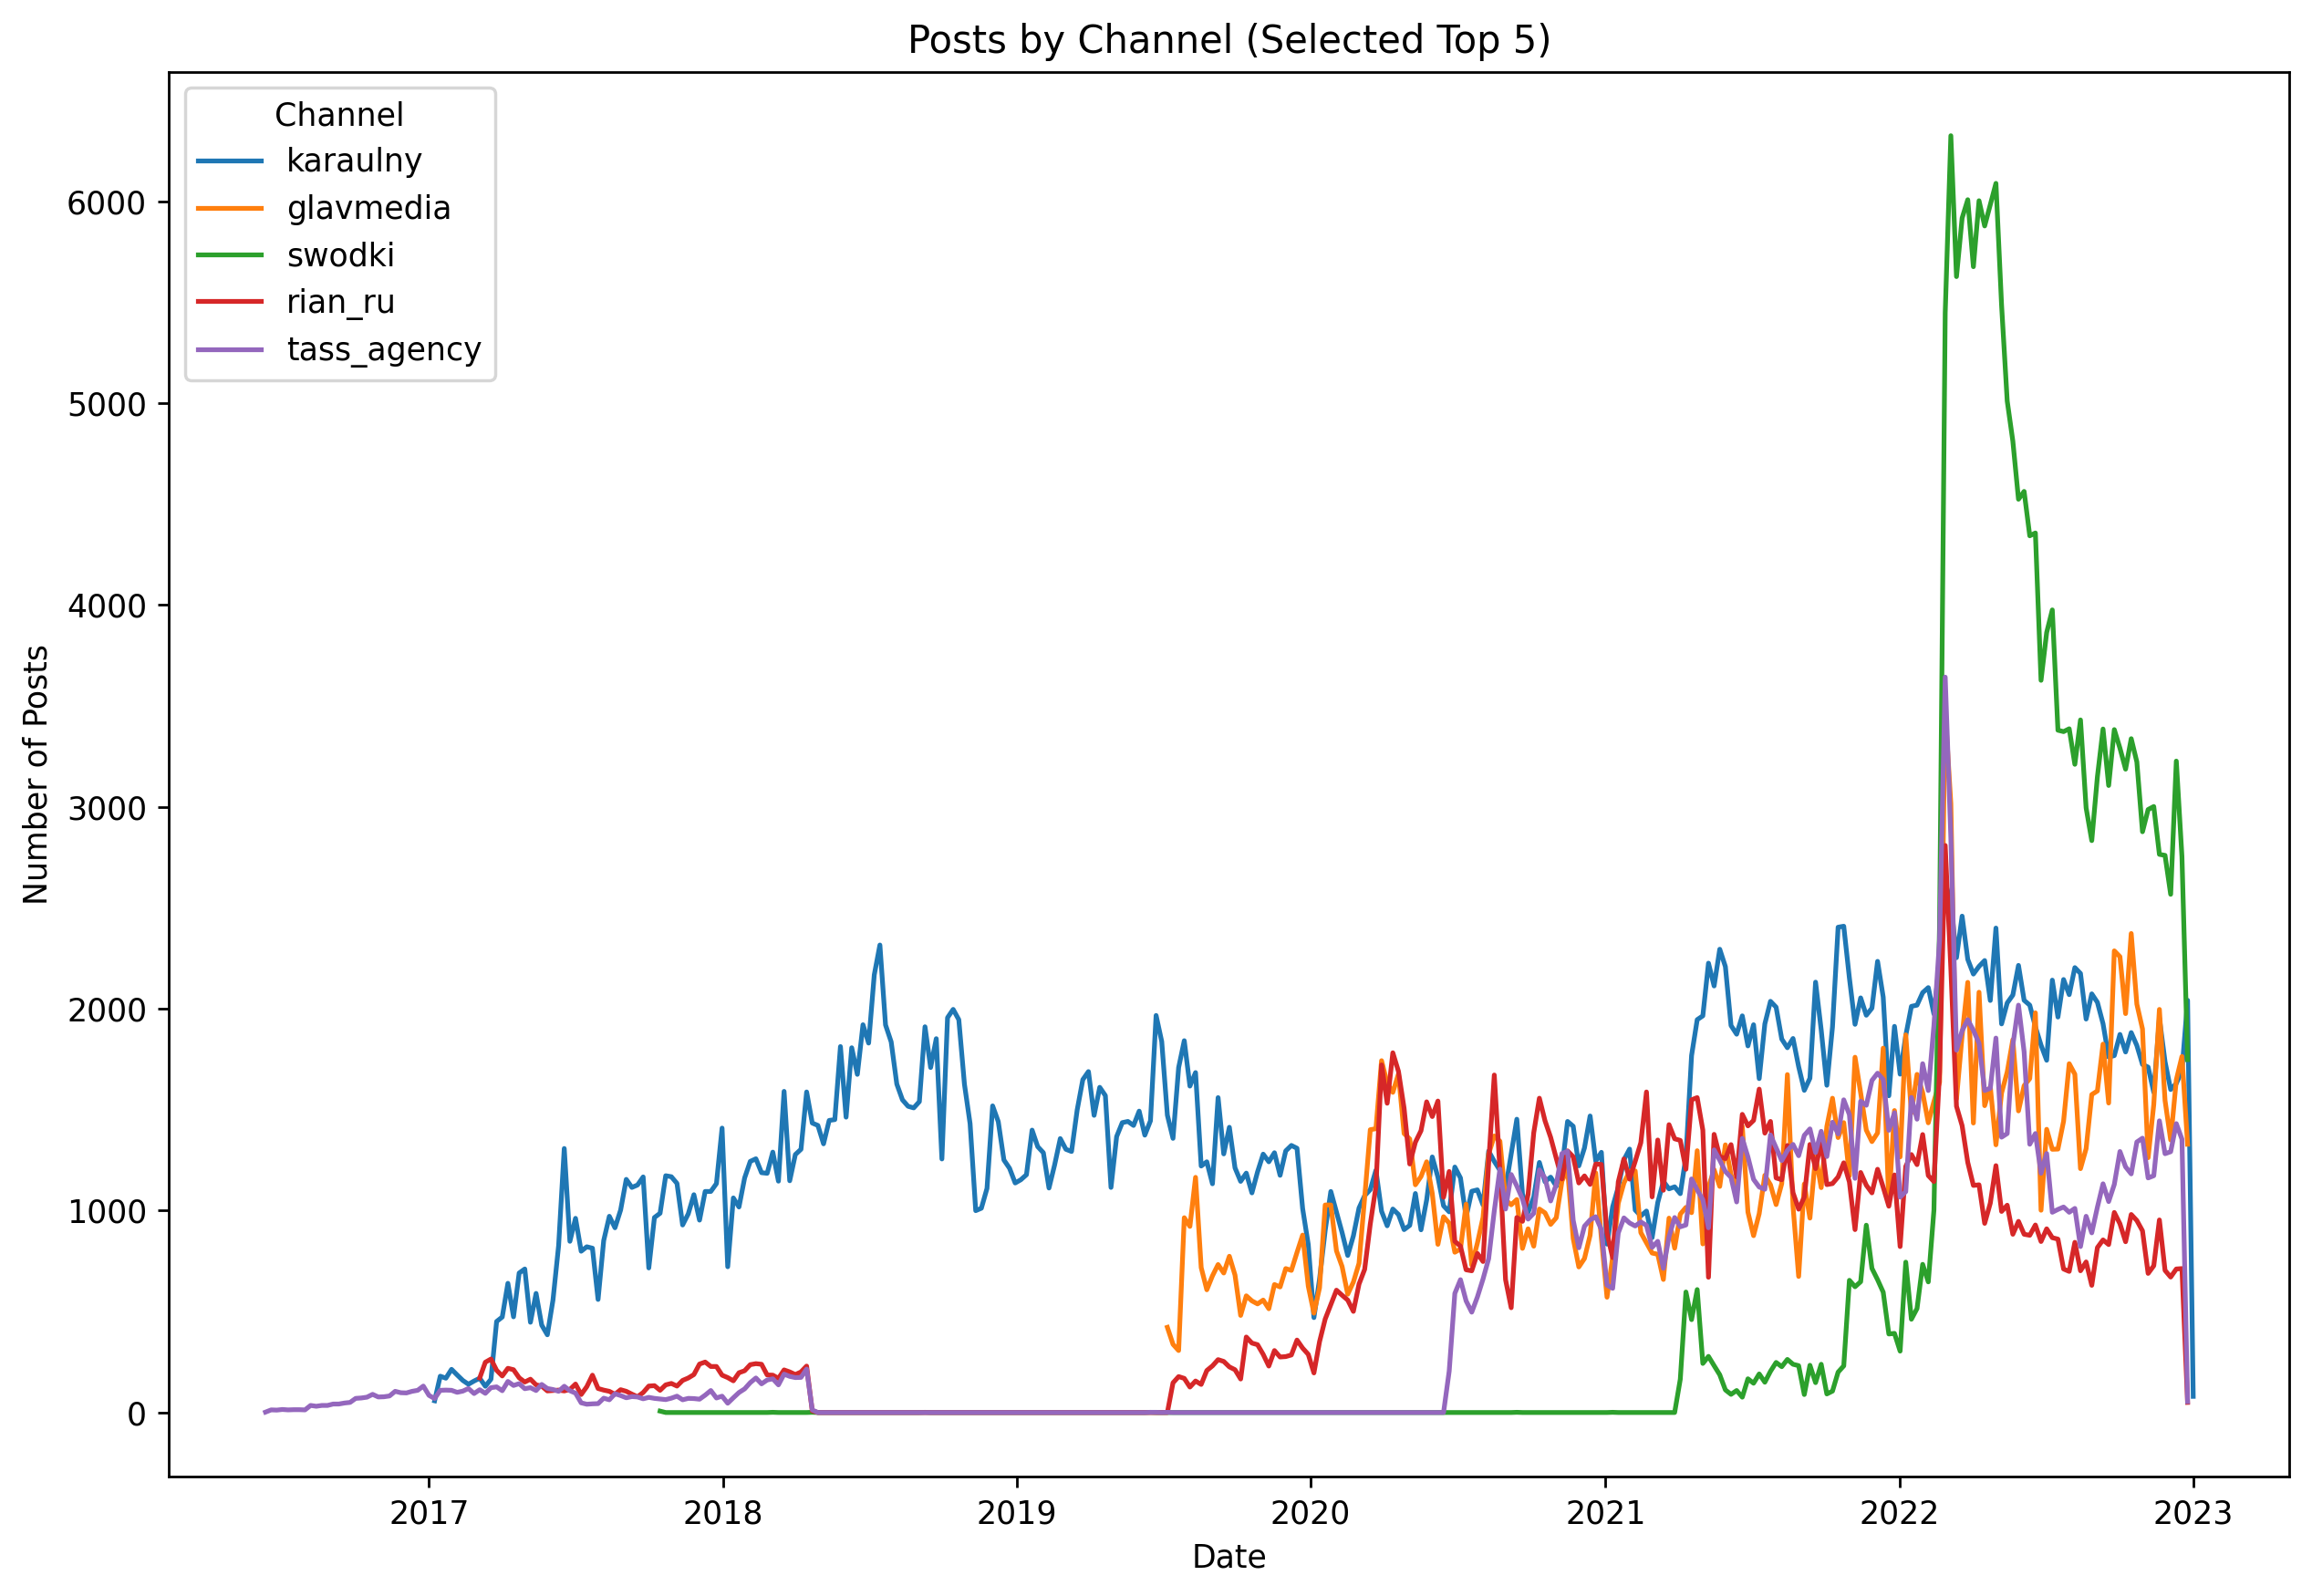

In [15]:
channel_post_counts = df.select(['channel']).to_pandas()
top_channels = channel_post_counts['channel'].value_counts().nlargest(5).index.tolist()

df_filtered = df.filter(df['channel'].is_in(top_channels))
df_pd = df_filtered.select(['datetime', 'channel']).to_pandas()

df_pd['message_count'] = 1
channel_counts = (
    df_pd.set_index('datetime')
    .groupby('channel')
    .resample('W')
    .sum()
    .drop(columns='channel')
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 8), dpi=250)
for channel in top_channels:
    channel_data = channel_counts[channel_counts['channel'] == channel]
    ax.plot(channel_data['datetime'], channel_data['message_count'], label=channel)

ax.set_title('Posts by Channel (Selected Top 5)')
ax.set_ylabel('Number of Posts')
ax.set_xlabel('Date')
ax.legend(title='Channel')
plt.show()

As we can note, almost all channels from the selected top-5 became significantly more active after the full-scale invasion in February 2022. This is especially true about `swodki` channel which started to post around 6 times more content after the invasion began. Moreover, this channel kept this amount of posting for a longer period than other channels. 

### How did the topics of the content changed over time?

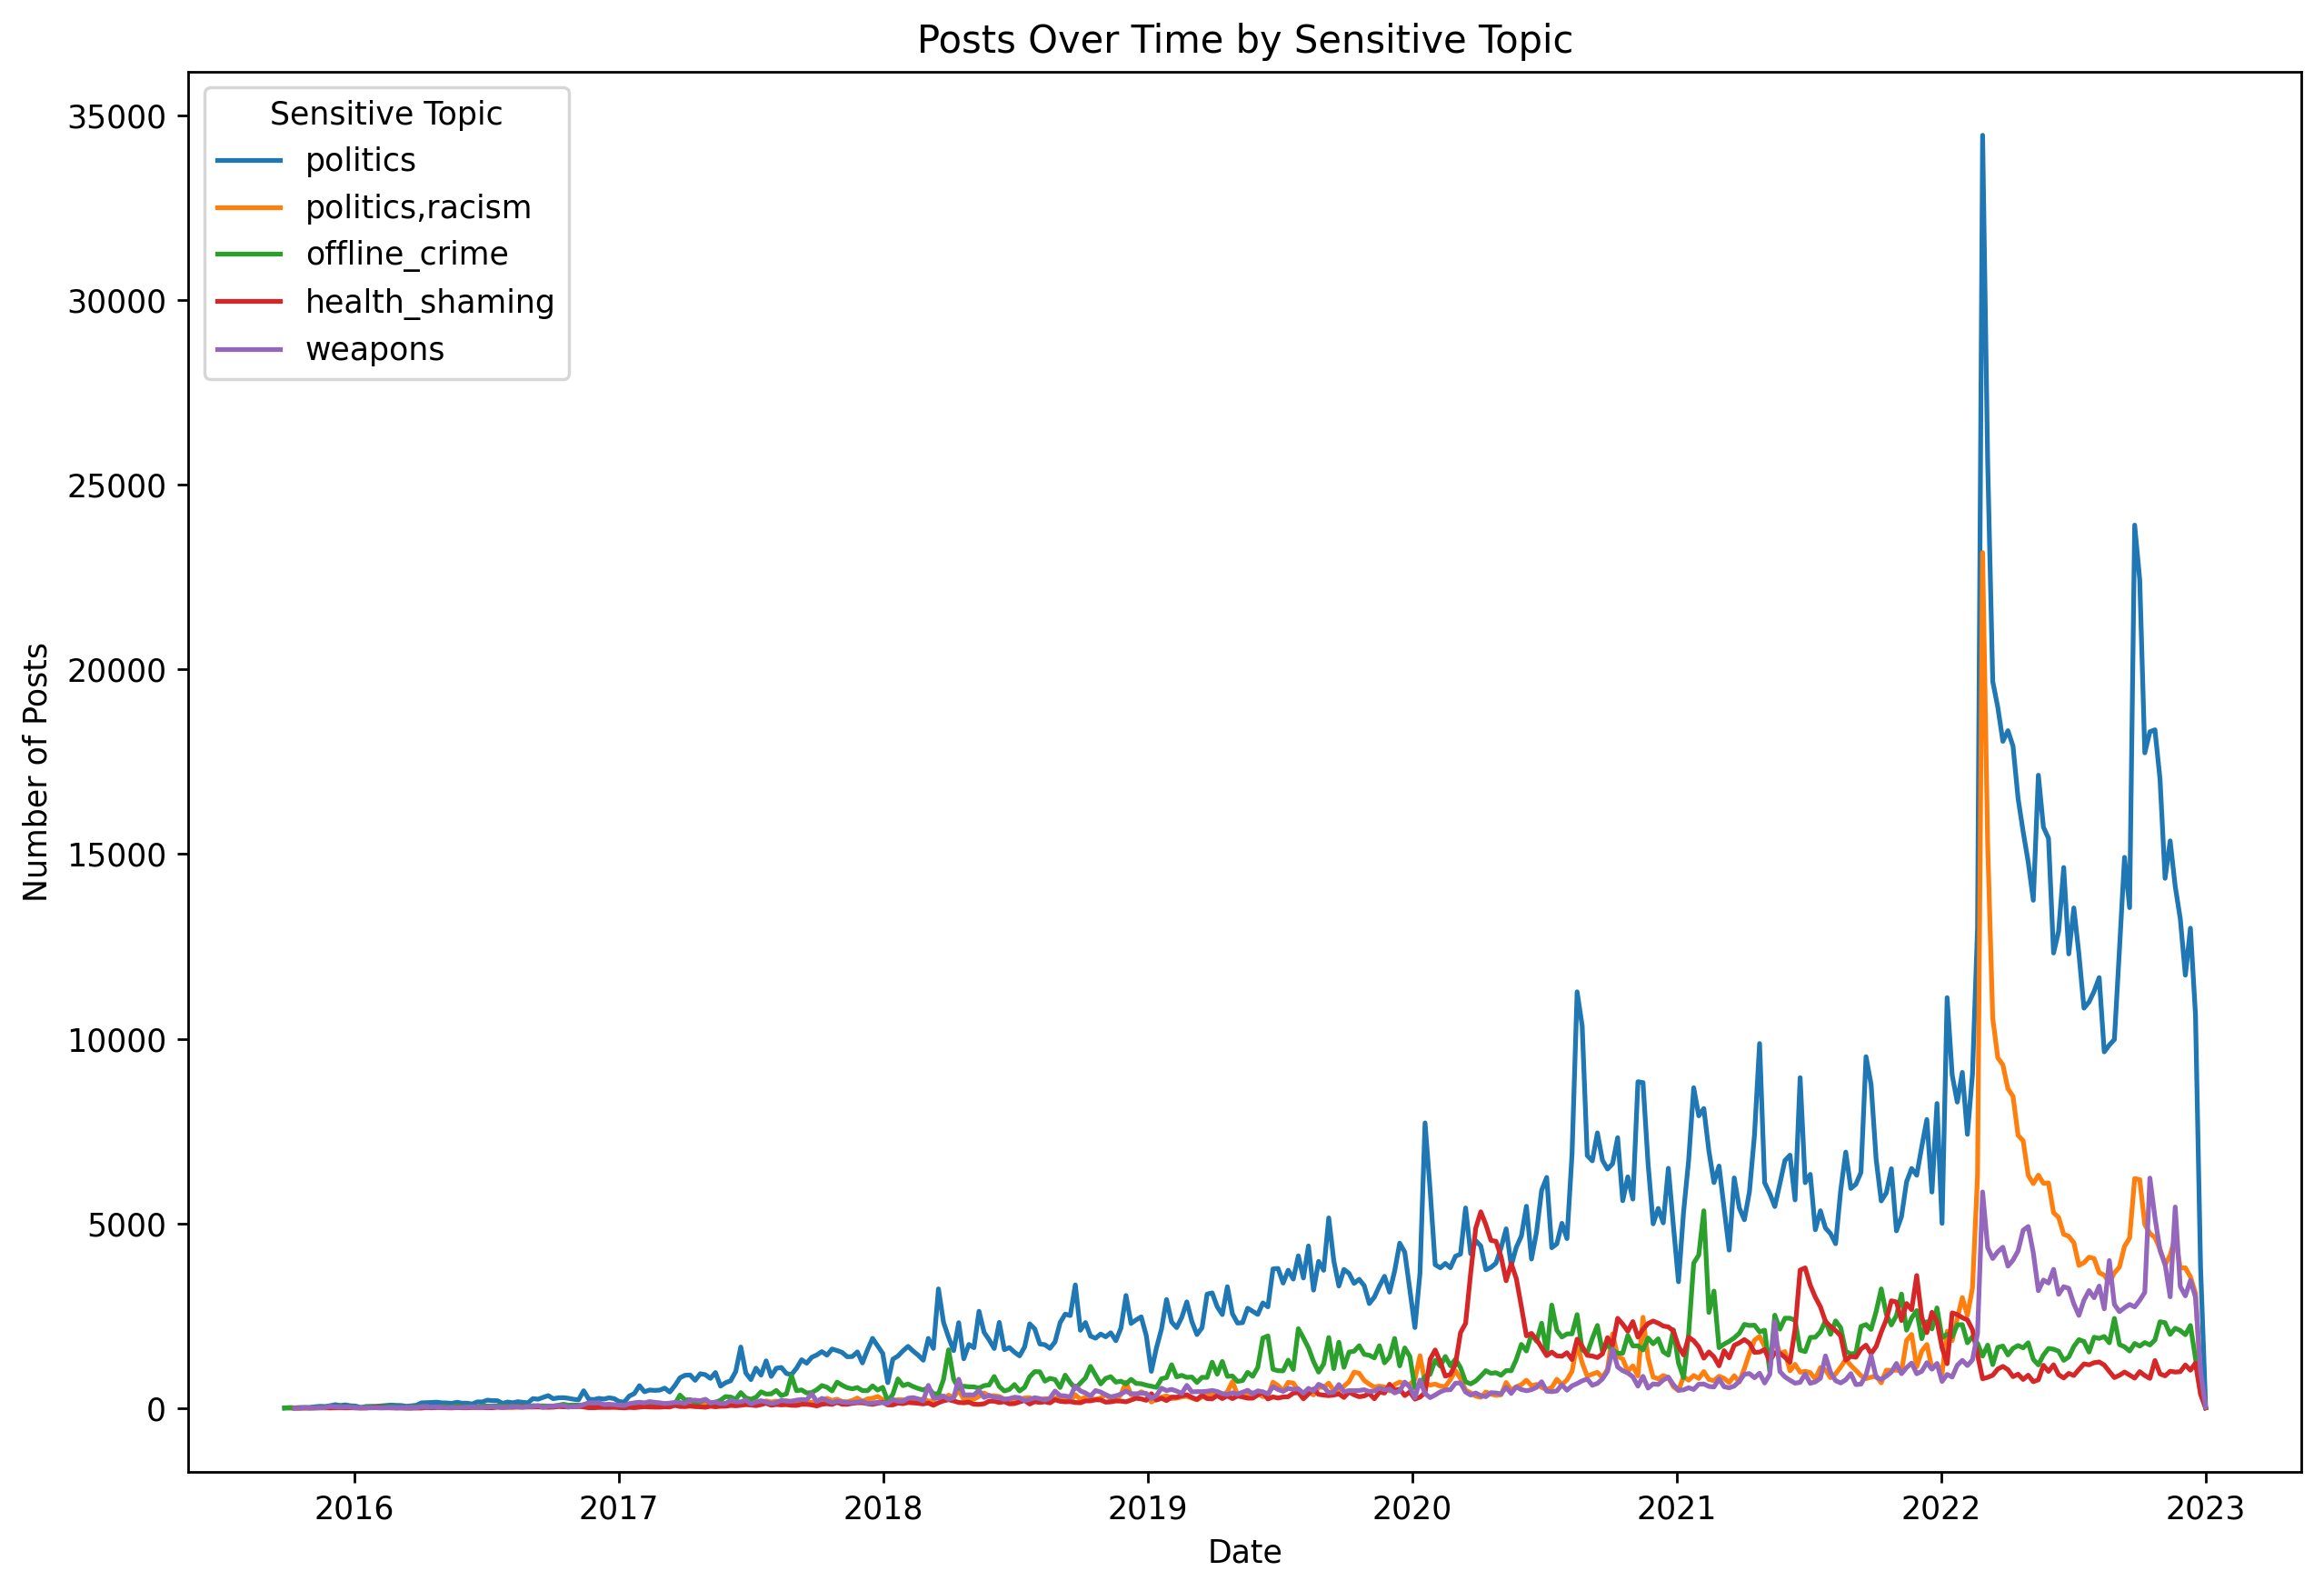

In [16]:
sensitive_topic_counts = df.select(['sensitive-topic']).to_pandas()
top_sensitive_topics = sensitive_topic_counts['sensitive-topic'].value_counts().nlargest(6).index.tolist()

if "none" in top_sensitive_topics:
    top_sensitive_topics.remove("none")

df_filtered = df.filter(df['sensitive-topic'].is_in(top_sensitive_topics))
df_pd = df_filtered.select(['datetime', 'sensitive-topic']).to_pandas()

df_pd['message_count'] = 1
sensitive_topic_counts = (
    df_pd.set_index('datetime')
    .groupby('sensitive-topic')
    .resample('W')
    .sum()
    .drop(columns='sensitive-topic')
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 8), dpi=250)
for topic in top_sensitive_topics:
    topic_data = sensitive_topic_counts[sensitive_topic_counts['sensitive-topic'] == topic]
    ax.plot(topic_data['datetime'], topic_data['message_count'], label=topic)

ax.set_title('Posts Over Time by Sensitive Topic')
ax.set_ylabel('Number of Posts')
ax.set_xlabel('Date')
ax.legend(title='Sensitive Topic')
plt.show()

From the above chart, there are clear spikes of posted content about politics after the full-scale invasion. Apart from that, the share posts about weapons has also increased significantly, which is not surprising. It is also worth noting that there is a clear bump of `health_shaming` topic in the beggining of 2020, which overlaps with a burst of COVID-19 pandemic. Finally, we can observe a spike of the `offline_crime` topic in the beginnning of 2021, which can be related with "protests" in support of alexey navaly fans during that period.

### How did topics change over time?

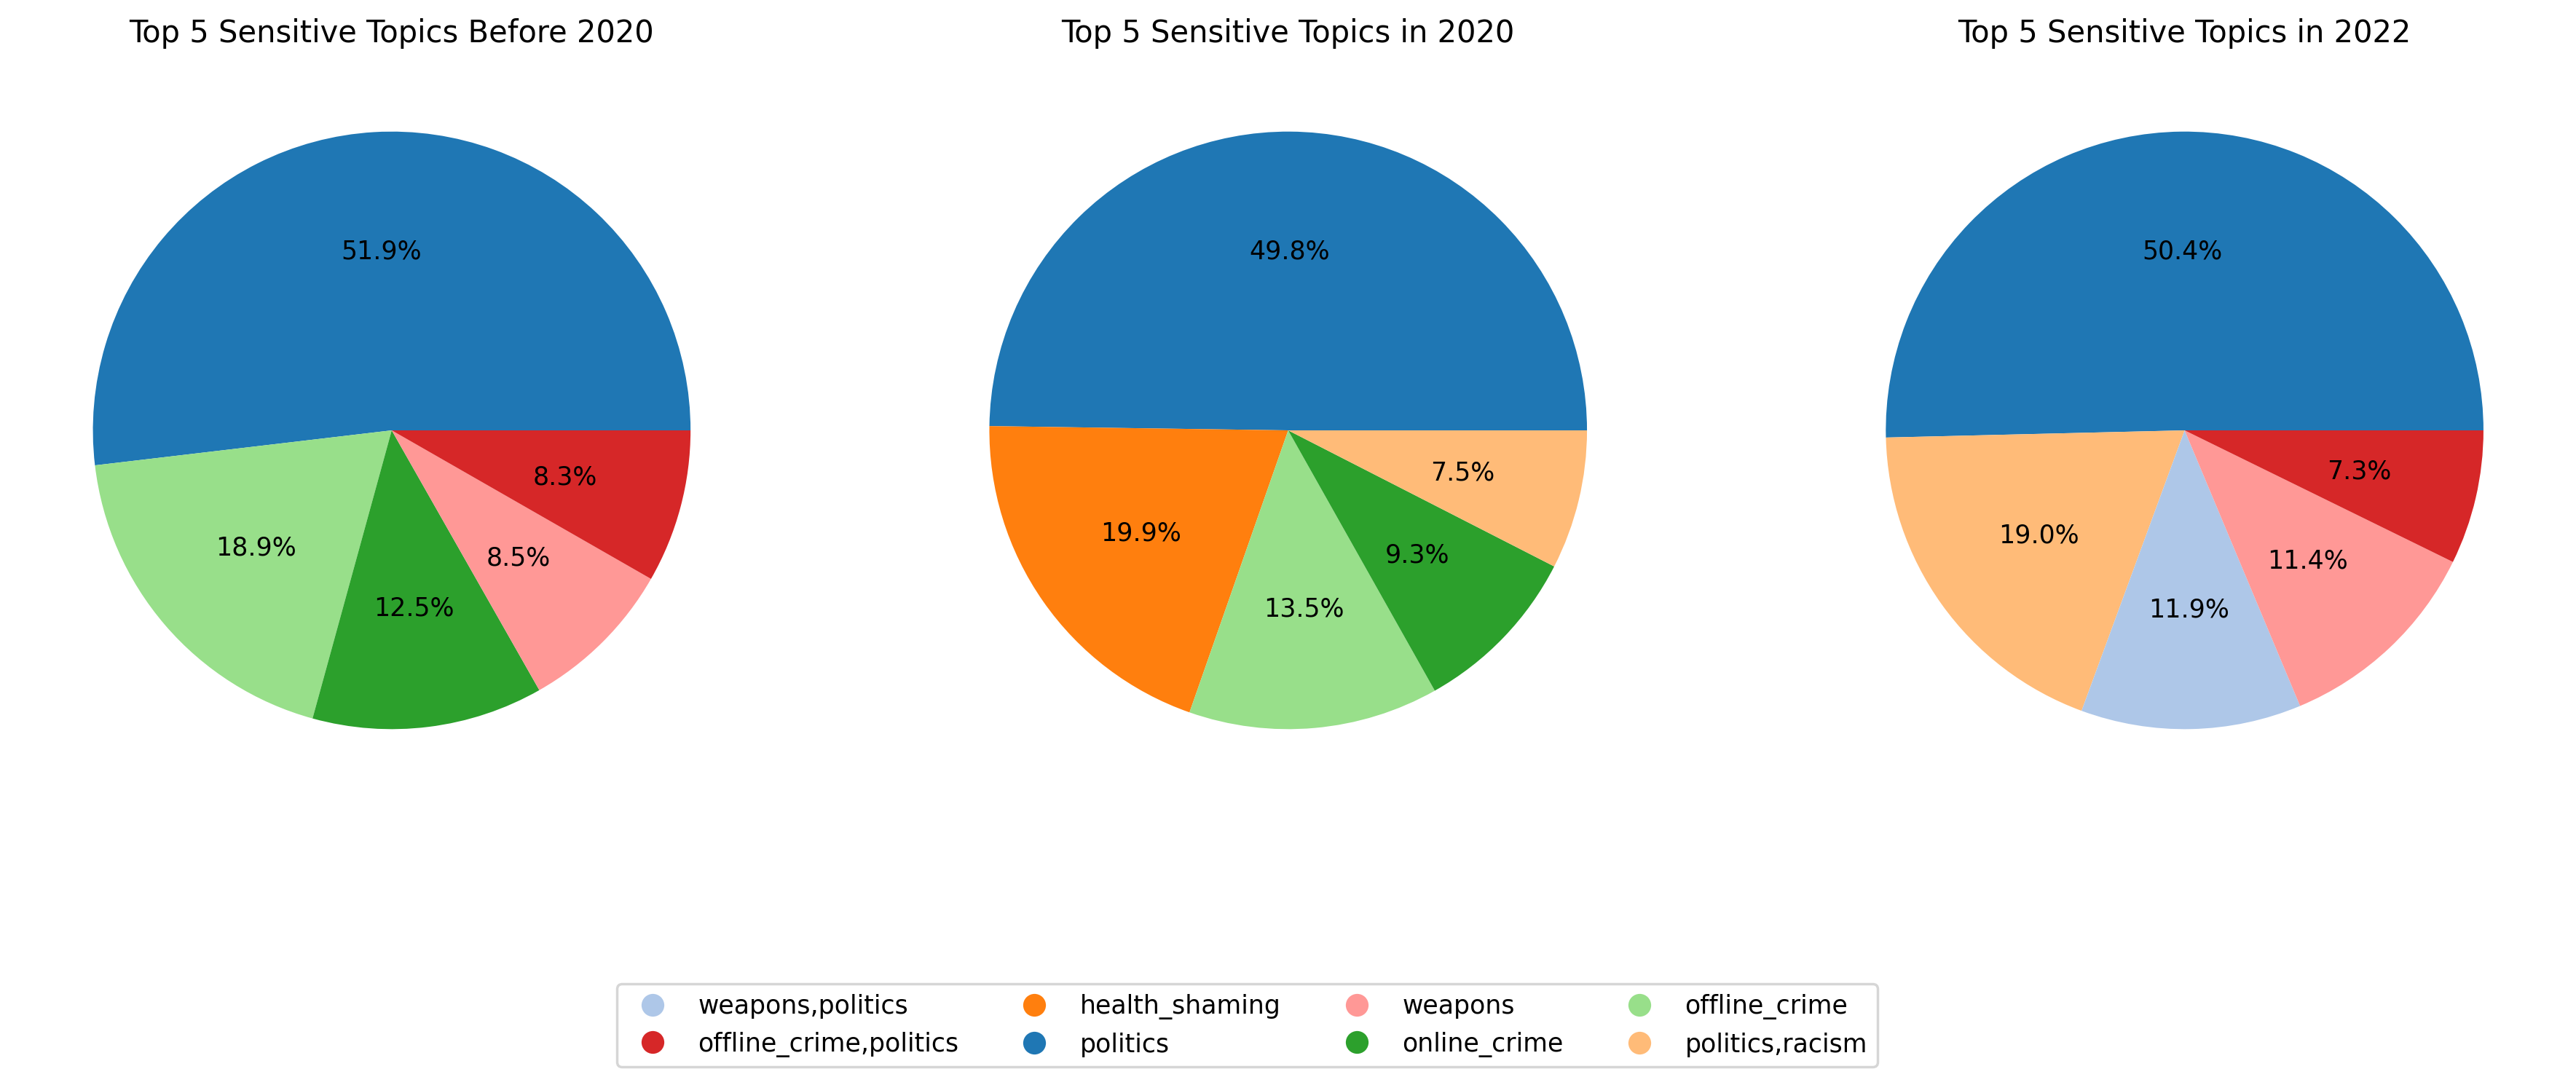

In [26]:
df_pd = df.select(['datetime', 'sensitive-topic']).to_pandas()

df_pd['year'] = df_pd['datetime'].dt.year

topics_before_2020 = df_pd[df_pd['year'] < 2020]['sensitive-topic'].value_counts()
topics_before_2020 = topics_before_2020[topics_before_2020.index != "none"].nlargest(5)

topics_2020 = df_pd[df_pd['year'] == 2020]['sensitive-topic'].value_counts()
topics_2020 = topics_2020[topics_2020.index != "none"].nlargest(5)

topics_2022 = df_pd[df_pd['year'] == 2022]['sensitive-topic'].value_counts()
topics_2022 = topics_2022[topics_2022.index != "none"].nlargest(5)

unique_topics = list(set(topics_before_2020.index).union(set(topics_2020.index)).union(set(topics_2022.index)))

colors = list(plt.cm.tab20.colors[:len(unique_topics)])
random.shuffle(colors)
color_map = {topic: colors[i] for i, topic in enumerate(unique_topics)}

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=250)

axes[0].pie(topics_before_2020, autopct='%1.1f%%', colors=[color_map[topic] for topic in topics_before_2020.index])
axes[0].set_title('Top 5 Sensitive Topics Before 2020')

axes[1].pie(topics_2020, autopct='%1.1f%%', colors=[color_map[topic] for topic in topics_2020.index])
axes[1].set_title('Top 5 Sensitive Topics in 2020')

axes[2].pie(topics_2022, autopct='%1.1f%%', colors=[color_map[topic] for topic in topics_2022.index])
axes[2].set_title('Top 5 Sensitive Topics in 2022')

# Create a common legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[topic], markersize=10) for topic in unique_topics]
labels = unique_topics
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.00000001), ncol=4)

plt.show()

Above, we can observe that politics topic remains a very stable leader over the years. However, there are some other noteworthy aspects:

- in 2020, the share of `health_shaming` becomes very significant, if we compare it to other charts (where it is not even present in the top-5 topics). Again, this is a good evidence that the prevalence of this topic was driven by COVID-19.
- in 2022, we observe an extreme shift to wartime content, which mostly touches on politics, weapons and xenophobia/racism. Overall, 4 out of 5 top sensitive topics are related to politics, which is a sign of the infospace becoming monothematic in the direction of politics.

### Did the level of toxicity change over time?

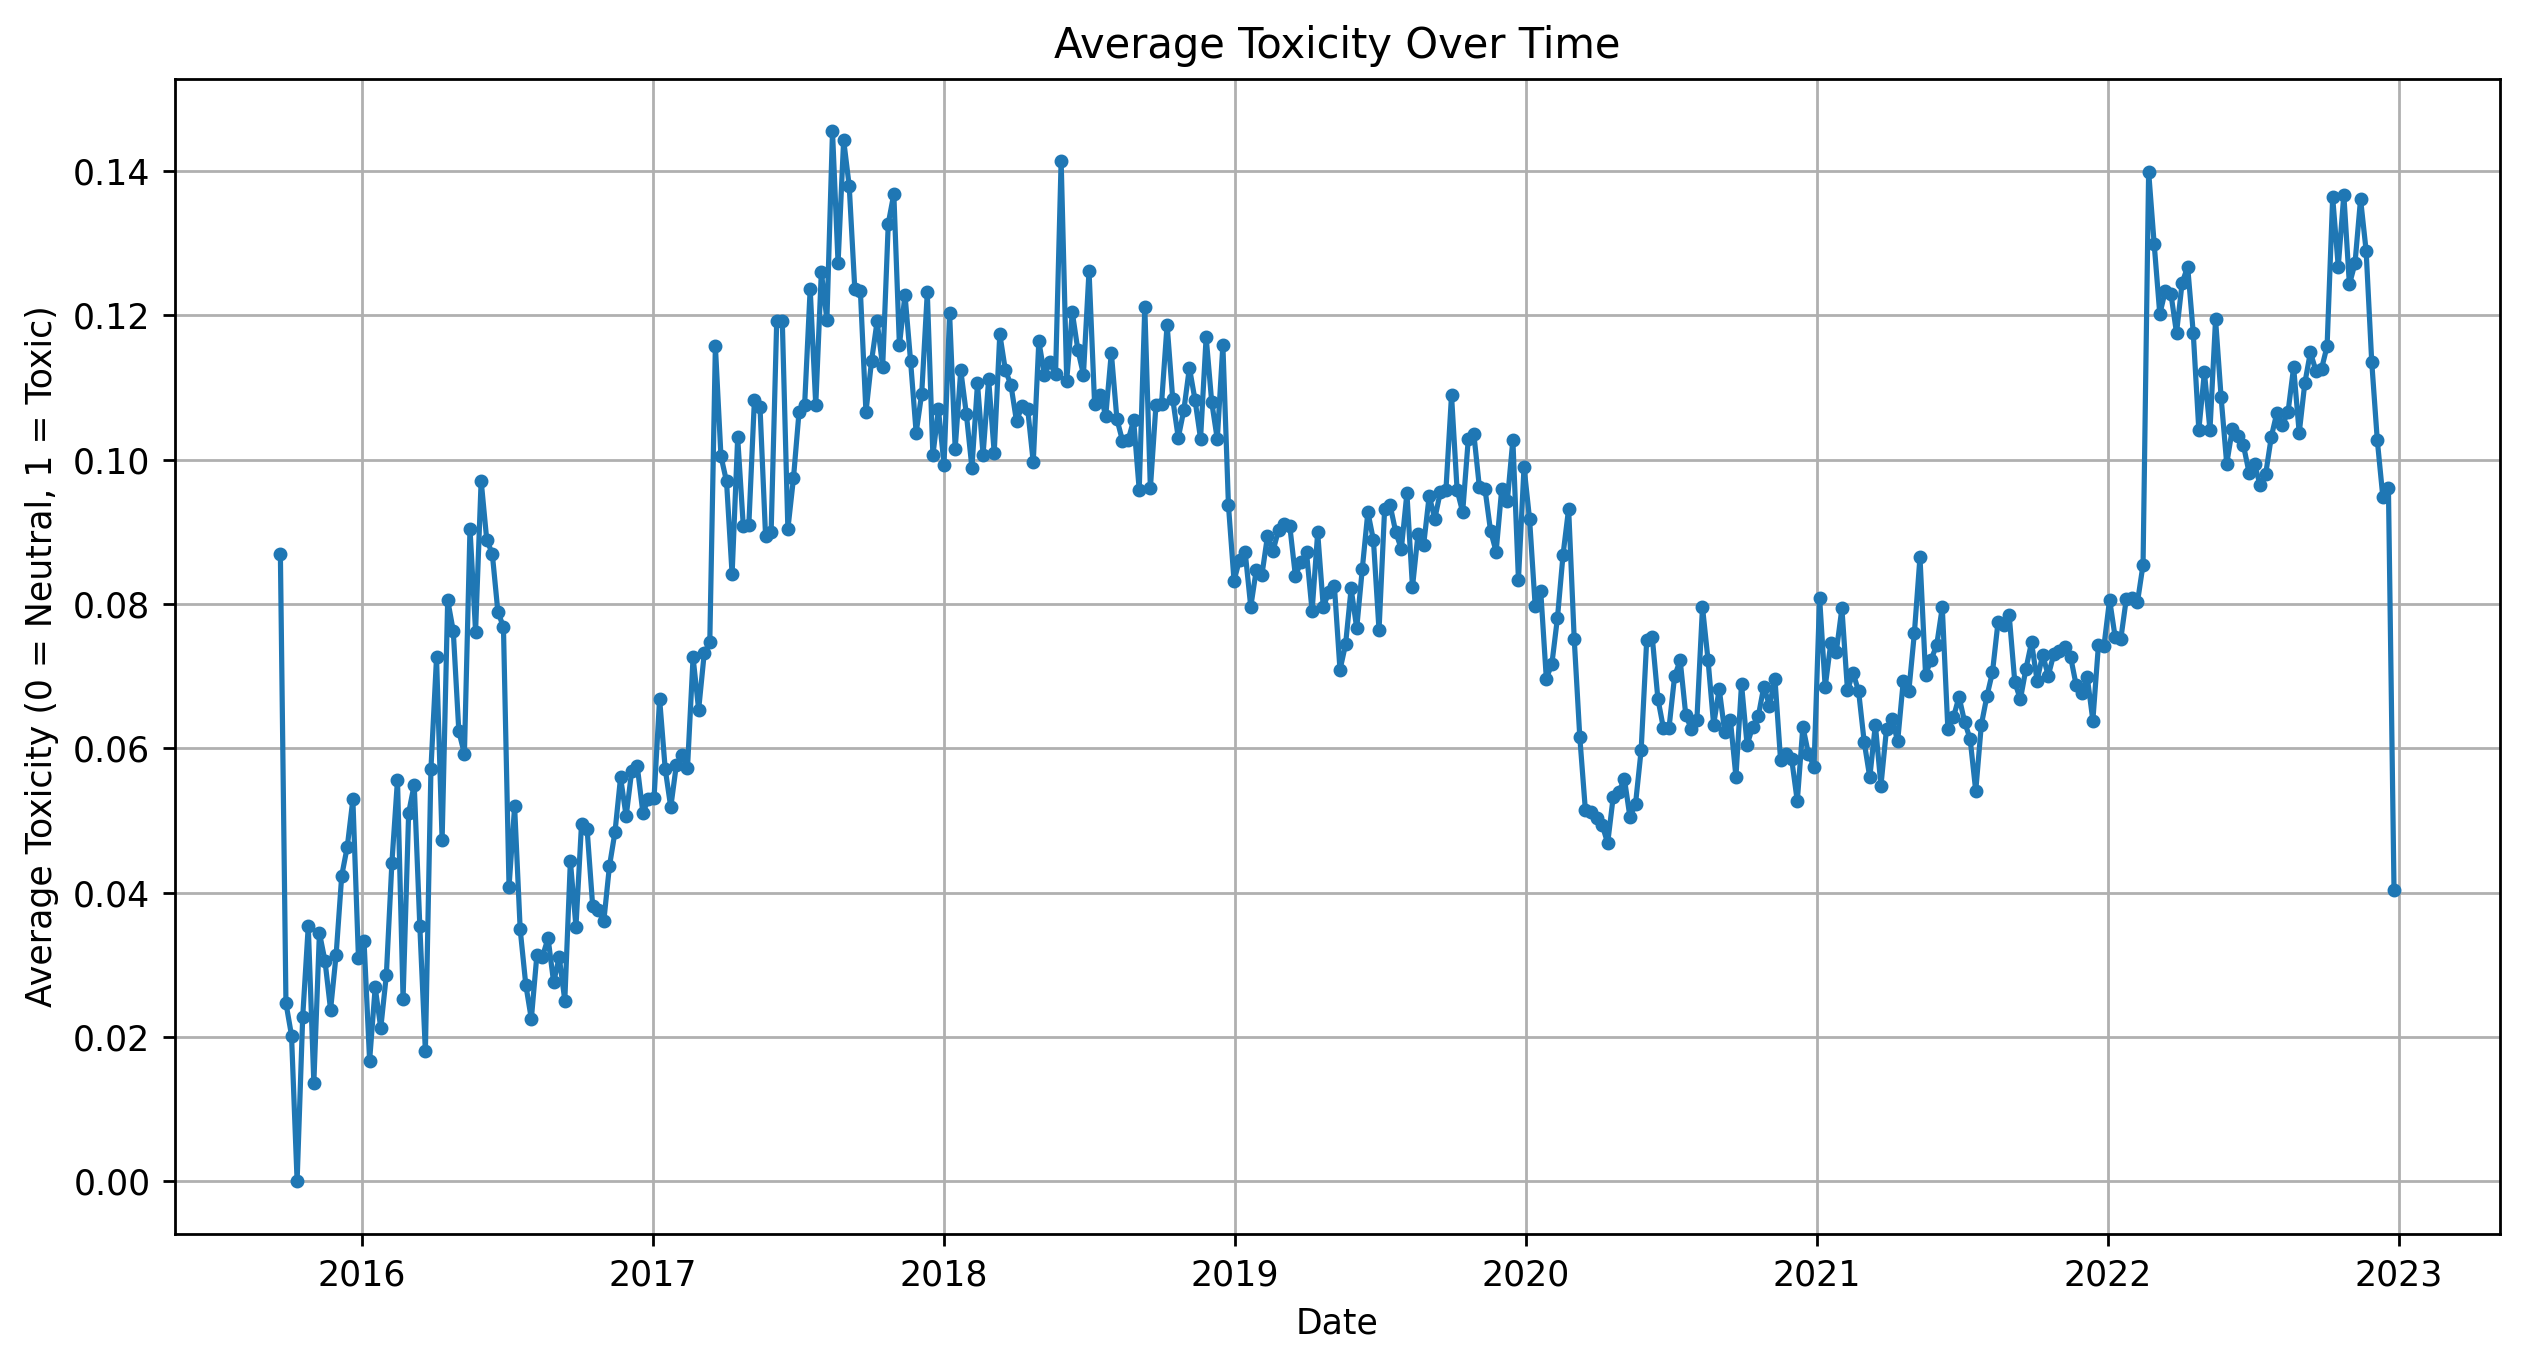

In [18]:
df_filtered = df.with_columns(
    pl.when(pl.col("toxicity") == "toxic").then(1).otherwise(0).alias("toxicity_numeric")
).sort("datetime")

toxicity_over_time = (
    df_filtered
    .group_by_dynamic("datetime", every="1w", closed="left")
    .agg(pl.col("toxicity_numeric").mean().alias("avg_toxicity"))
    .sort("datetime")
)

toxicity_over_time_pd = toxicity_over_time.to_pandas()

plt.figure(figsize=(12, 6), dpi=250)
plt.plot(toxicity_over_time_pd['datetime'], toxicity_over_time_pd['avg_toxicity'], marker='o', markersize=3)
plt.title('Average Toxicity Over Time')
plt.ylabel('Average Toxicity (0 = Neutral, 1 = Toxic)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

On the above chart, we can notice couple of significant rises of toxicity levels. The first two bumps were more gradual and peaked in the second half of 2017. The second spike clearly occurred during the start of full-scale invasion. Let's observe some of the most popular and influential channels present in our dataset. 

### How the toxicity of the most influetial channels change over time?

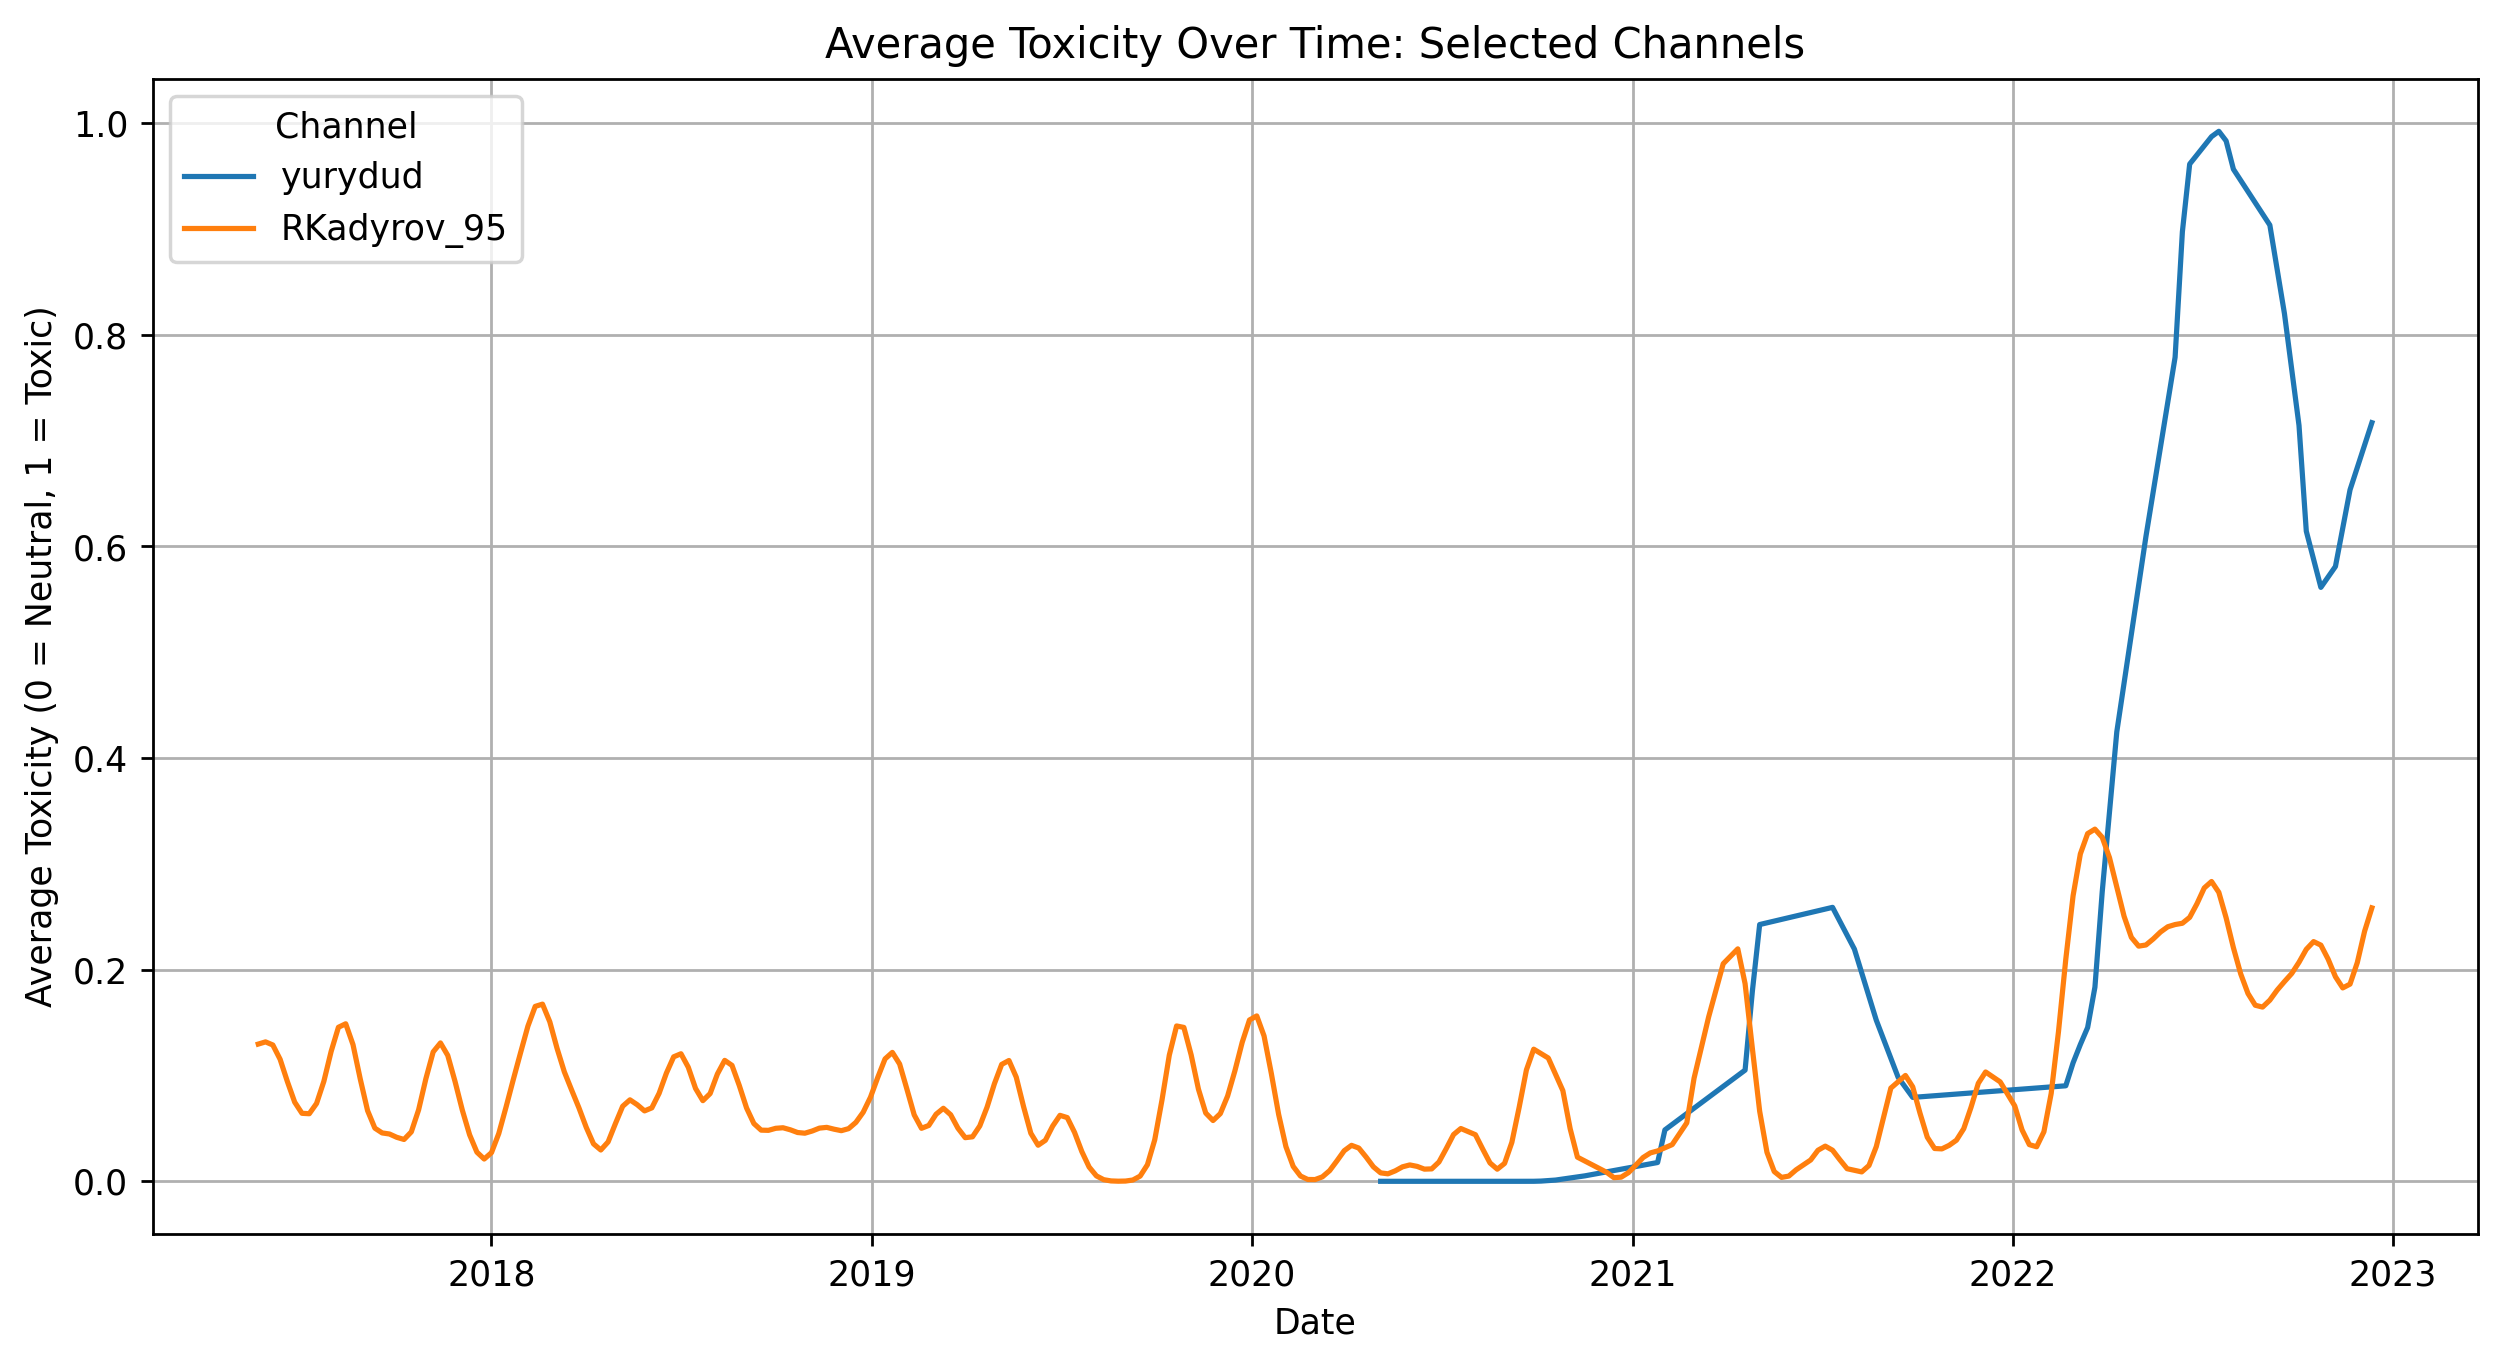

In [19]:
from scipy.ndimage import gaussian_filter1d

channels_of_interest = [ "yurydud", "RKadyrov_95"]

df_filtered = df.filter(pl.col("channel").is_in(channels_of_interest))
df_filtered = df_filtered.with_columns(
    pl.when(pl.col("toxicity") == "toxic").then(1).otherwise(0).alias("toxicity_numeric")
).sort("datetime")

toxicity_over_time = (
    df_filtered
    .group_by_dynamic("datetime", every="1w", closed="left", by="channel")
    .agg(pl.col("toxicity_numeric").mean().alias("avg_toxicity"))
    .sort("datetime")
)

toxicity_over_time_pd = toxicity_over_time.to_pandas()

fig, ax = plt.subplots(figsize=(12, 6), dpi=250)
for channel in channels_of_interest:
    channel_data = toxicity_over_time_pd[toxicity_over_time_pd['channel'] == channel]
    smoothed_toxicity = gaussian_filter1d(channel_data['avg_toxicity'], sigma=2)
    ax.plot(channel_data['datetime'], smoothed_toxicity, label=channel)

ax.set_title('Average Toxicity Over Time: Selected Channels')
ax.set_ylabel('Average Toxicity (0 = Neutral, 1 = Toxic)')
ax.set_xlabel('Date')
ax.legend(title='Channel')
ax.grid(True)

plt.show()

As we can see, levels of toxicity of these channels coinside with a general trend across all channels: noticeable bump present since the start of the invasion. However, we can see that the content of yurii dud (a "good" russian blogger known for his disagreement with aggressive war politics performed by his state) spikes toward toxicity far more intensely than posts of a pro-putin russian leader ramzan kadyrov. 

# **Conclusions**

Our above analysis of the Telegram channels dataset revealed a number of interesting patterns. 

1. The most prevalent topic which accounts for nearly 60% of the labelled messages is politics. However, several significant channels such as `karaulny`, `tass_agency`, `glavmedia`, `swodki` were responsible for spreading vast amounts of messages labelled as terrorist and crime topics. Apart from that, significant contribution of spreading this content can be devoted to `medvedev_telegram`, `RVVoenkor` and `breakingmash`, since these channels were very effective at transcribing terrorist and crime content at massive audiences, gaining billions of views.

2. Channels employ various strategies to engage users into their content. Some channels take a more aggresive stance and create content with high toxicity levels, while others lean toward a neutral manner of expression. Our analysis has shown that those channels that post content that is more toxic  tend to gain more than twice as many views as those employing a neutral stance. This observation points out that social meadia users are far more engaged by emotionally pressing and strong content.

3. Content have a highly dynamic nature and is strongly dependent on political and socioeconomical environment. This was pointed out by our temporal analysis, where we shown that there was a lot of variation between proportional shares of sensitive topics depending on the analyzed time period. Moreover, telegram channels tend to be very reactive to significant external circumstances and events, such as the beginning of the full-scale russias invasion into Ukraine. During this period, we observed significant spikes of the channels activity, as well as shift in the covered sensitive topics.

Overall, the analysis underscores the role of Telegram as a significant platform for information exchange, particularly in sensitive and politically charged contexts. The findings highlight the need for continued monitoring and understanding of content dynamics to better anticipate and respond to changes in public discourse.